<a href="https://colab.research.google.com/github/rabnawaz172/Diabetic-Retinopathy/blob/main/Untitled190.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import librosa
import pandas as pd
from sklearn.utils import shuffle

# Assuming the Google Drive dataset folder is loaded to a local directory using Google Colab
# Mount Google Drive first to access the files

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Processing 111 files in class 'NORM'
Processing 117 files in class 'PATHOL'
Processing 111 files in class 'NORM'
Processing 117 files in class 'PATHOL'
Processing 111 files in class 'NORM'
Processing 117 files in class 'PATHOL'


/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Processing 47 files in class 'NORM'
Processing 49 files in class 'PATHOL'
Processing 47 files in class 'NORM'
Processing 49 files in class 'PATHOL'
Processing 47 files in class 'NORM'
Processing 49 files in class 'PATHOL'
Training and evaluating DT with MFCC features...
Training and evaluating DT with Mel-Spectrogram features...
Training and evaluating DT with Chroma features...
Training and evaluating DT with Combined features...
Training and evaluating RF with MFCC features...
Training and evaluating RF with Mel-Spectrogram features...
Training and evaluating RF with Chroma features...
Training and evaluating RF with Combined features...
Training and evaluating SVM with MFCC features...
Training and evaluating SVM with Mel-Spectrogram features...
Training and evaluating SVM with Chroma features...
Training and evaluating SVM with Combined features...
Training and evaluating NB with MFCC features...
Training and evaluating NB with Mel-Spectrogram features...
Training and evaluating NB

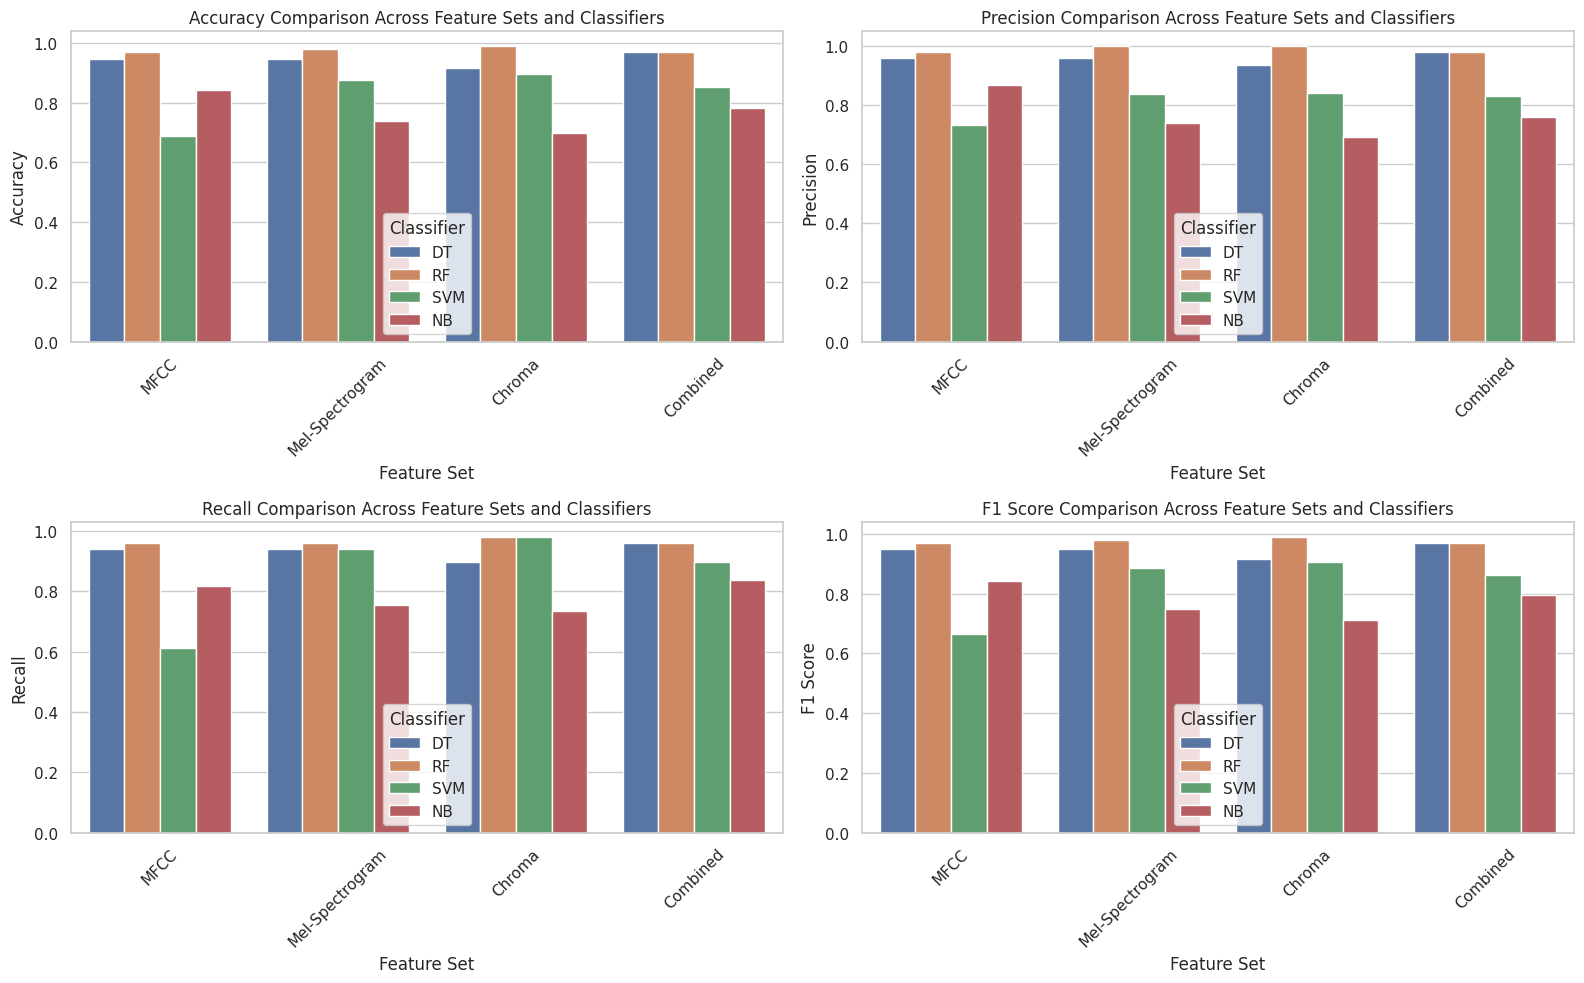

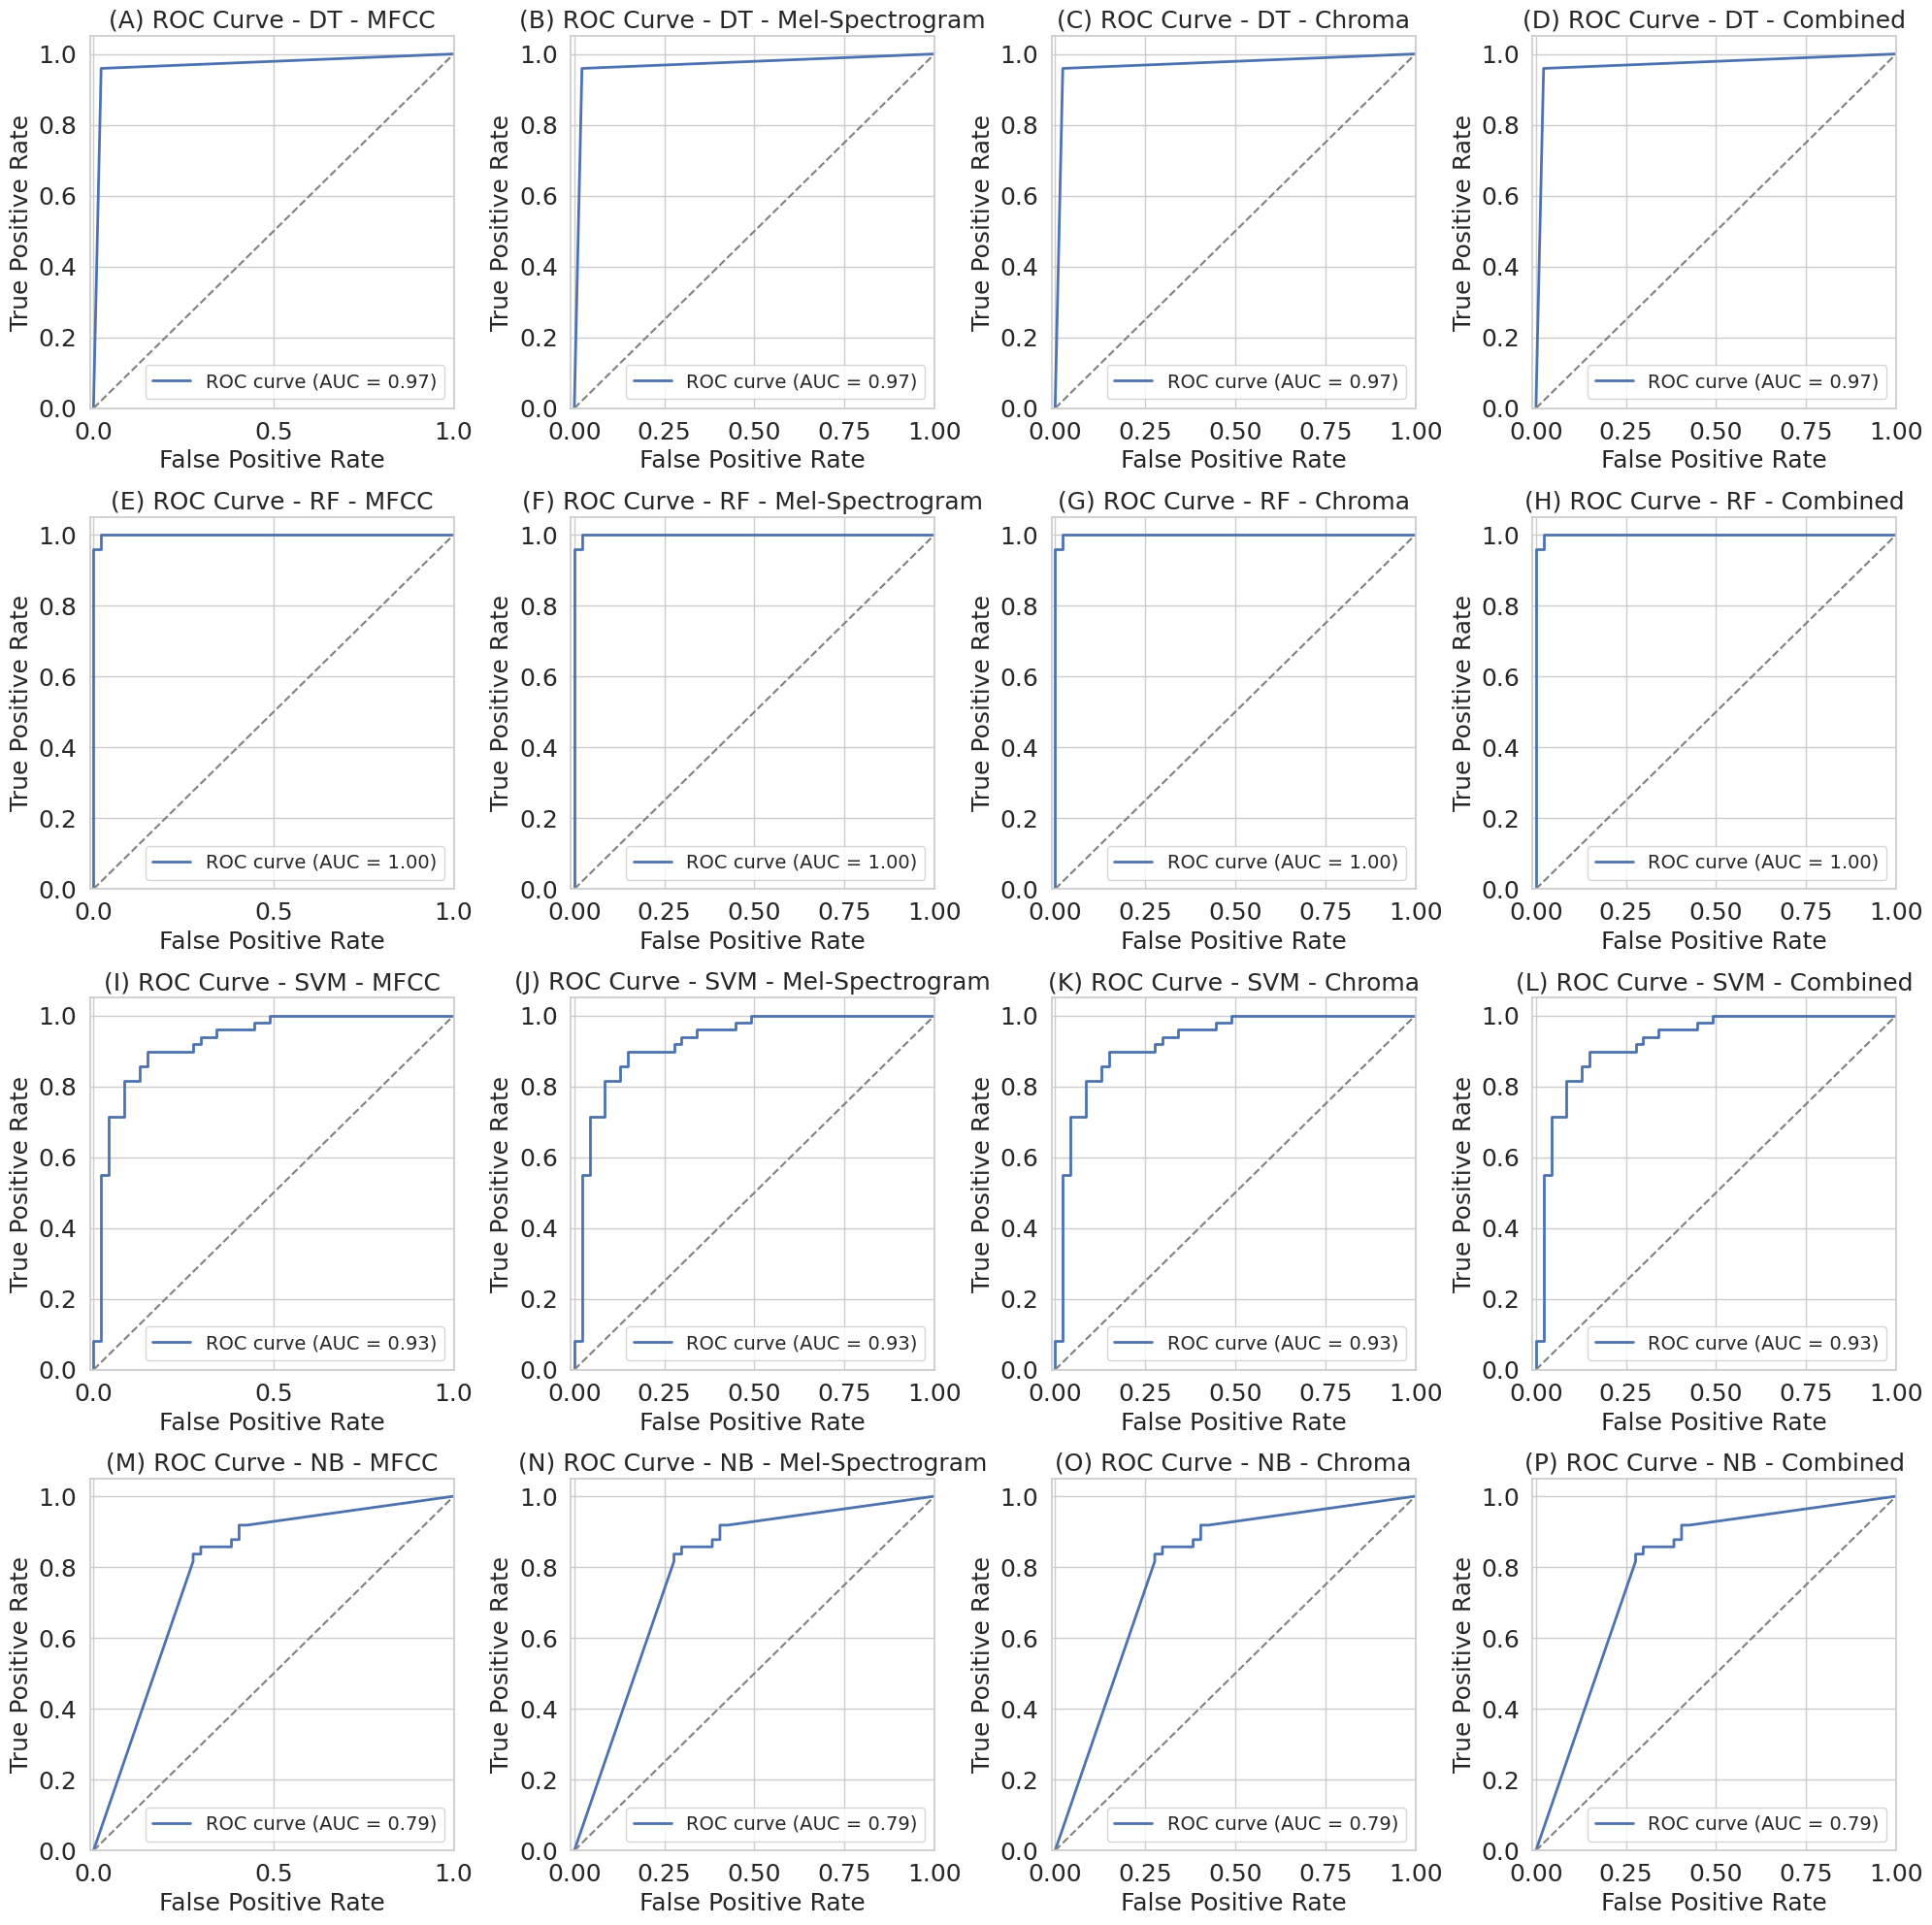

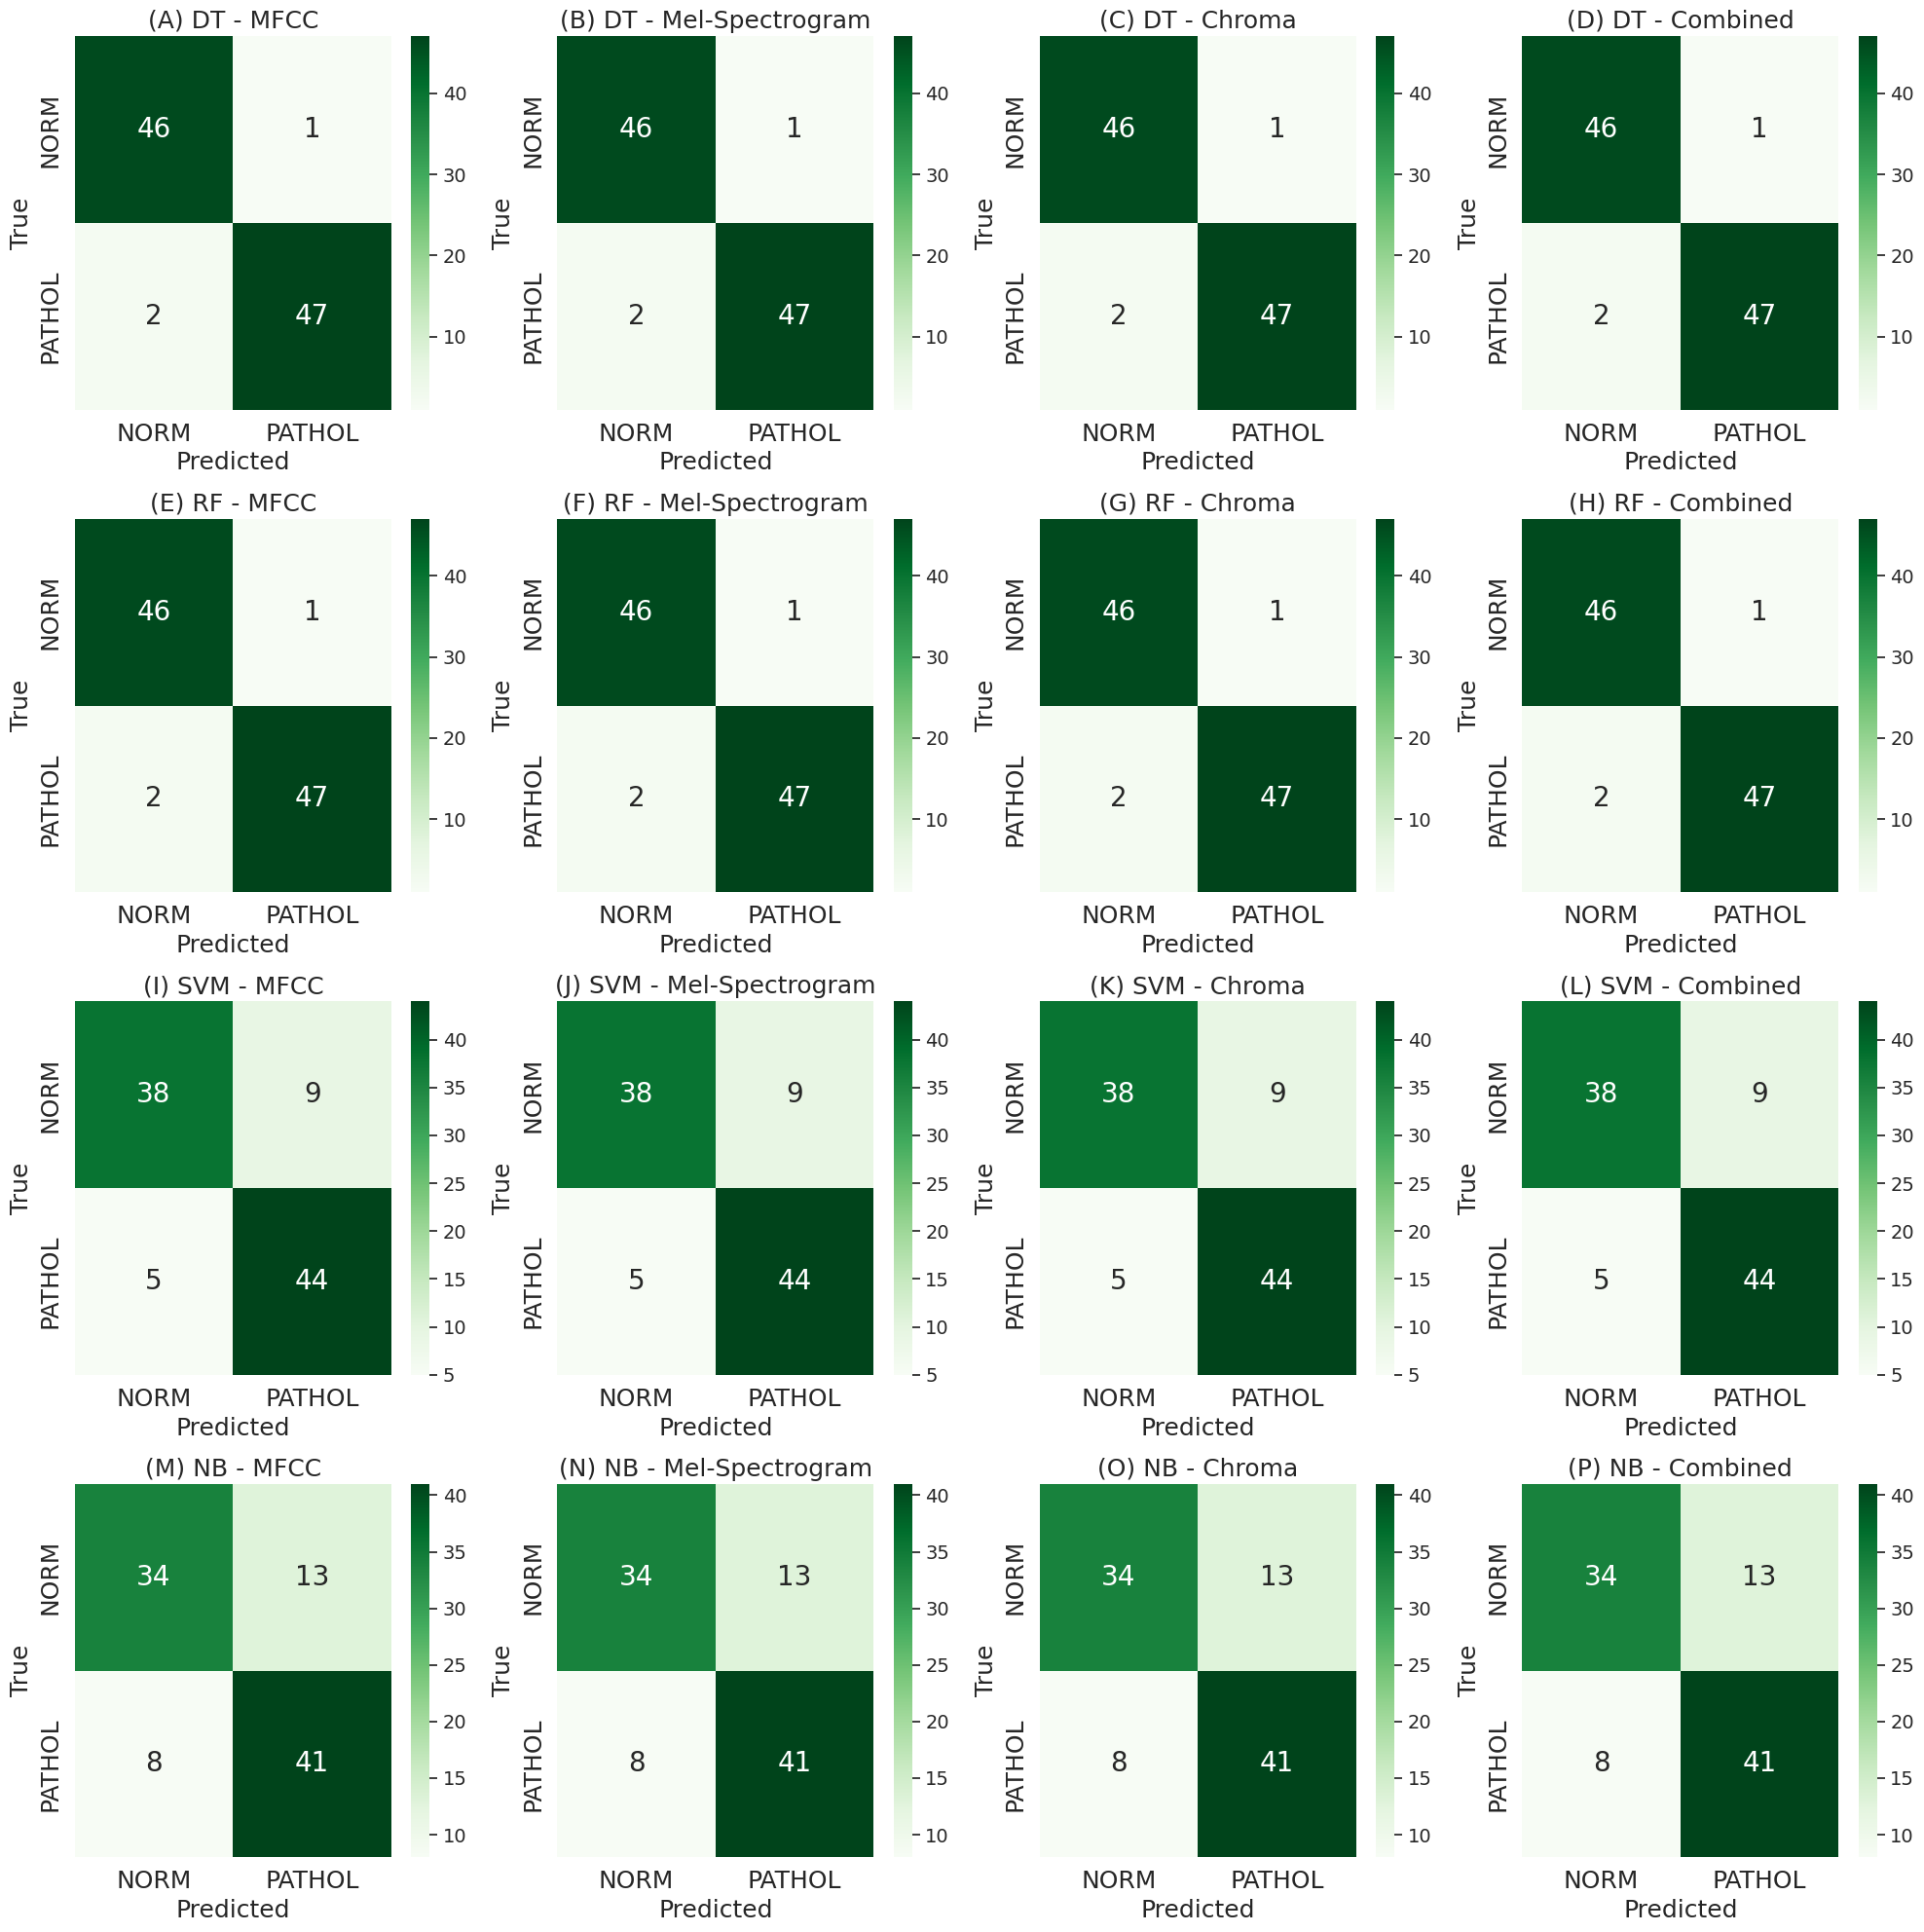

In [ ]:
import os
import numpy as np
import librosa
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import glob
import matplotlib.pyplot as plt

# Set seaborn style
sns.set(style="whitegrid")

# Paths and labels
base_path = '/content/drive/MyDrive/Voice_2/Train'  # Training dataset
test_path = '/content/drive/MyDrive/Voice_2/Test_2'  # Test dataset
classes = ['NORM', 'PATHOL']
labels = {'NORM': 0, 'PATHOL': 1}

# Feature extraction functions
def extract_mfcc_features(file_path, n_mfcc=13, max_len=130):
    """Extract MFCC-based features."""
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfccs_delta = librosa.feature.delta(mfccs)
        mfccs_delta2 = librosa.feature.delta(mfccs, order=2)
        feature_vector = np.hstack((mfccs, mfccs_delta, mfccs_delta2))
        if feature_vector.shape[1] < max_len:
            pad_width = max_len - feature_vector.shape[1]
            feature_vector = np.pad(feature_vector, ((0, 0), (0, pad_width)), mode='constant')
        elif feature_vector.shape[1] > max_len:
            feature_vector = feature_vector[:, :max_len]
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        feature_vector = np.zeros((n_mfcc * 3, max_len))
    return feature_vector

def extract_melspectrogram_features(file_path, n_mels=128, max_len=130):
    """Extract Mel-Spectrogram-based features."""
    try:
        y, sr = librosa.load(file_path, sr=None)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibel scale
        if mel_spec_db.shape[1] < max_len:
            pad_width = max_len - mel_spec_db.shape[1]
            feature_vector = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
        elif mel_spec_db.shape[1] > max_len:
            feature_vector = mel_spec_db[:, :max_len]
        else:
            feature_vector = mel_spec_db  # In case the dimensions are already correct
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        feature_vector = np.zeros((n_mels, max_len))  # Default to zero array in case of error
    return feature_vector

def extract_chroma_features(file_path, n_chroma=12, max_len=130):
    """Extract Chroma-based features."""
    try:
        y, sr = librosa.load(file_path, sr=None)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=n_chroma)
        if chroma.shape[1] < max_len:
            pad_width = max_len - chroma.shape[1]
            feature_vector = np.pad(chroma, ((0, 0), (0, pad_width)), mode='constant')
        elif chroma.shape[1] > max_len:
            feature_vector = chroma[:, :max_len]
        else:
            feature_vector = chroma  # In case the dimensions are already correct
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        feature_vector = np.zeros((n_chroma, max_len))  # Default to zero array in case of error
    return feature_vector

def prepare_dataset(base_path, feature_extract_func):
    features = []
    target = []
    max_len = 130

    for class_name in classes:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)

        print(f"Processing {len(file_list)} files in class '{class_name}'")

        for file in file_list:
            feature_vector = feature_extract_func(file, max_len=max_len)
            features.append(feature_vector)
            target.append(labels[class_name])

    X = np.array(features)
    Y = np.array(target)
    n_samples, n_channels, n_frames = X.shape
    X = X.reshape(n_samples, -1)

    return X, Y

# Extract features from different techniques and combine
def combine_features():
    X_mfcc_train, Y_train = prepare_dataset(base_path, extract_mfcc_features)
    X_mel_train, Y_train = prepare_dataset(base_path, extract_melspectrogram_features)
    X_chroma_train, Y_train = prepare_dataset(base_path, extract_chroma_features)

    # Combine all features
    X_combined_train = np.hstack((X_mfcc_train, X_mel_train, X_chroma_train))

    # Test dataset
    X_mfcc_test, Y_test = prepare_dataset(test_path, extract_mfcc_features)
    X_mel_test, Y_test = prepare_dataset(test_path, extract_melspectrogram_features)
    X_chroma_test, Y_test = prepare_dataset(test_path, extract_chroma_features)

    # Combine all features for test data
    X_combined_test = np.hstack((X_mfcc_test, X_mel_test, X_chroma_test))

    return X_mfcc_train, X_mel_train, X_chroma_train, X_combined_train, X_mfcc_test, X_mel_test, X_chroma_test, X_combined_test, Y_train, Y_test

# Define classifiers
classifiers = {
    'DT': DecisionTreeClassifier(random_state=42),
    'RF': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'NB': GaussianNB()
}

# Evaluate classifiers for each feature set and combined
metrics = {
    'Classifier': [],
    'Feature Set': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# Get features
X_mfcc_train, X_mel_train, X_chroma_train, X_combined_train, X_mfcc_test, X_mel_test, X_chroma_test, X_combined_test, Y_train, Y_test = combine_features()

# Evaluate classifiers on each feature set
for name, clf in classifiers.items():
    for feature_set, X_train, X_test in zip(['MFCC', 'Mel-Spectrogram', 'Chroma', 'Combined'],
                                            [X_mfcc_train, X_mel_train, X_chroma_train, X_combined_train],
                                            [X_mfcc_test, X_mel_test, X_chroma_test, X_combined_test]):
        print(f"Training and evaluating {name} with {feature_set} features...")
        clf.fit(X_train, Y_train)  # Train on the selected feature set
        Y_pred = clf.predict(X_test)  # Predict on the test dataset

        # Calculate metrics
        acc = accuracy_score(Y_test, Y_pred)
        prec = precision_score(Y_test, Y_pred, zero_division=0)
        rec = recall_score(Y_test, Y_pred, zero_division=0)
        f1 = f1_score(Y_test, Y_pred, zero_division=0)

        # Append metrics to the dictionary
        metrics['Classifier'].append(name)
        metrics['Feature Set'].append(feature_set)
        metrics['Accuracy'].append(acc)
        metrics['Precision'].append(prec)
        metrics['Recall'].append(rec)
        metrics['F1 Score'].append(f1)

# Convert metrics dictionary to a pandas DataFrame
metrics_df = pd.DataFrame(metrics)

# Display results
print("\nMetrics for each classifier and feature set:")
print(metrics_df)

# Plot metrics
plt.figure(figsize=(16, 10))
for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1 Score'], 1):
    plt.subplot(2, 2, i)
    sns.barplot(x='Feature Set', y=metric, hue='Classifier', data=metrics_df)
    plt.title(f'{metric} Comparison Across Feature Sets and Classifiers')
    plt.xlabel('Feature Set')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

import os
import numpy as np
import librosa
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import glob
import matplotlib.pyplot as plt

# Create subplots for the ROC curves
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

label_count = 0  # Counter to label plots
feature_sets = {
    'MFCC': X_mfcc_train,
    'Mel-Spectrogram': X_mel_train,
    'Chroma': X_chroma_train,
    'Combined': X_combined_train
}

# Later in your ROC curve plotting section:
for i, (model_name, classifier) in enumerate(classifiers.items()):
    for j, (feature_set_name, X_train) in enumerate(feature_sets.items()):
        # Predict on the test set (assumes models are already trained)
        Y_pred = classifier.predict(X_test)

        # Compute ROC curve and AUC for the current model
        fpr, tpr, _ = roc_curve(Y_test, classifier.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve
        ax_roc = axes[i, j]  # Get the corresponding subplot for ROC curve
        ax_roc.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        ax_roc.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (chance level)
        ax_roc.set_xlim([-0.01, 1.0])  # Set x-axis to start from -0.01
        ax_roc.set_ylim([0.0, 1.05])  # Set y-axis to [0, 1]
        ax_roc.set_title(f'({chr(65 + label_count)}) ROC Curve - {model_name} - {feature_set_name}', fontsize=18)
        ax_roc.set_xlabel('False Positive Rate', fontsize=18)
        ax_roc.set_ylabel('True Positive Rate', fontsize=18)
        ax_roc.tick_params(axis='both', which='major', labelsize=18)
        ax_roc.legend(loc='lower right', fontsize=14)

        label_count += 1

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


import os
import numpy as np
import librosa
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import glob
import matplotlib.pyplot as plt

# Create subplots for the ROC curves
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

label_count = 0  # Counter to label plots
feature_sets = {
    'MFCC': X_mfcc_train,
    'Mel-Spectrogram': X_mel_train,
    'Chroma': X_chroma_train,
    'Combined': X_combined_train
}

# Later in your ROC curve plotting section:
for i, (model_name, classifier) in enumerate(classifiers.items()):
    for j, (feature_set_name, X_train) in enumerate(feature_sets.items()):
        # Predict on the test set (assumes models are already trained)
        Y_pred = classifier.predict(X_test)
        # Compute confusion matrix
        from sklearn.metrics import confusion_matrix # Import confusion_matrix
        cm = confusion_matrix(Y_test, Y_pred)

        # Plot the confusion matrix
        ax = axes[i, j]  # Get the corresponding subplot
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes, ax=ax,
                    annot_kws={"size": 20})

        ax.set_title(f'({chr(65 + label_count)}) {model_name} - {feature_set_name}', fontsize=18)
        ax.set_xlabel('Predicted', fontsize=18)
        ax.set_ylabel('True', fontsize=18)

        # Adjust tick font size
        ax.tick_params(axis='both', which='major', labelsize=18)

        # Adjust colorbar tick size
        colorbar = ax.collections[0].colorbar
        colorbar.ax.tick_params(labelsize=14)  # Set colorbar tick font size to 14

        label_count += 1


# Adjust layout and show the plot
plt.tight_layout()
plt.show()

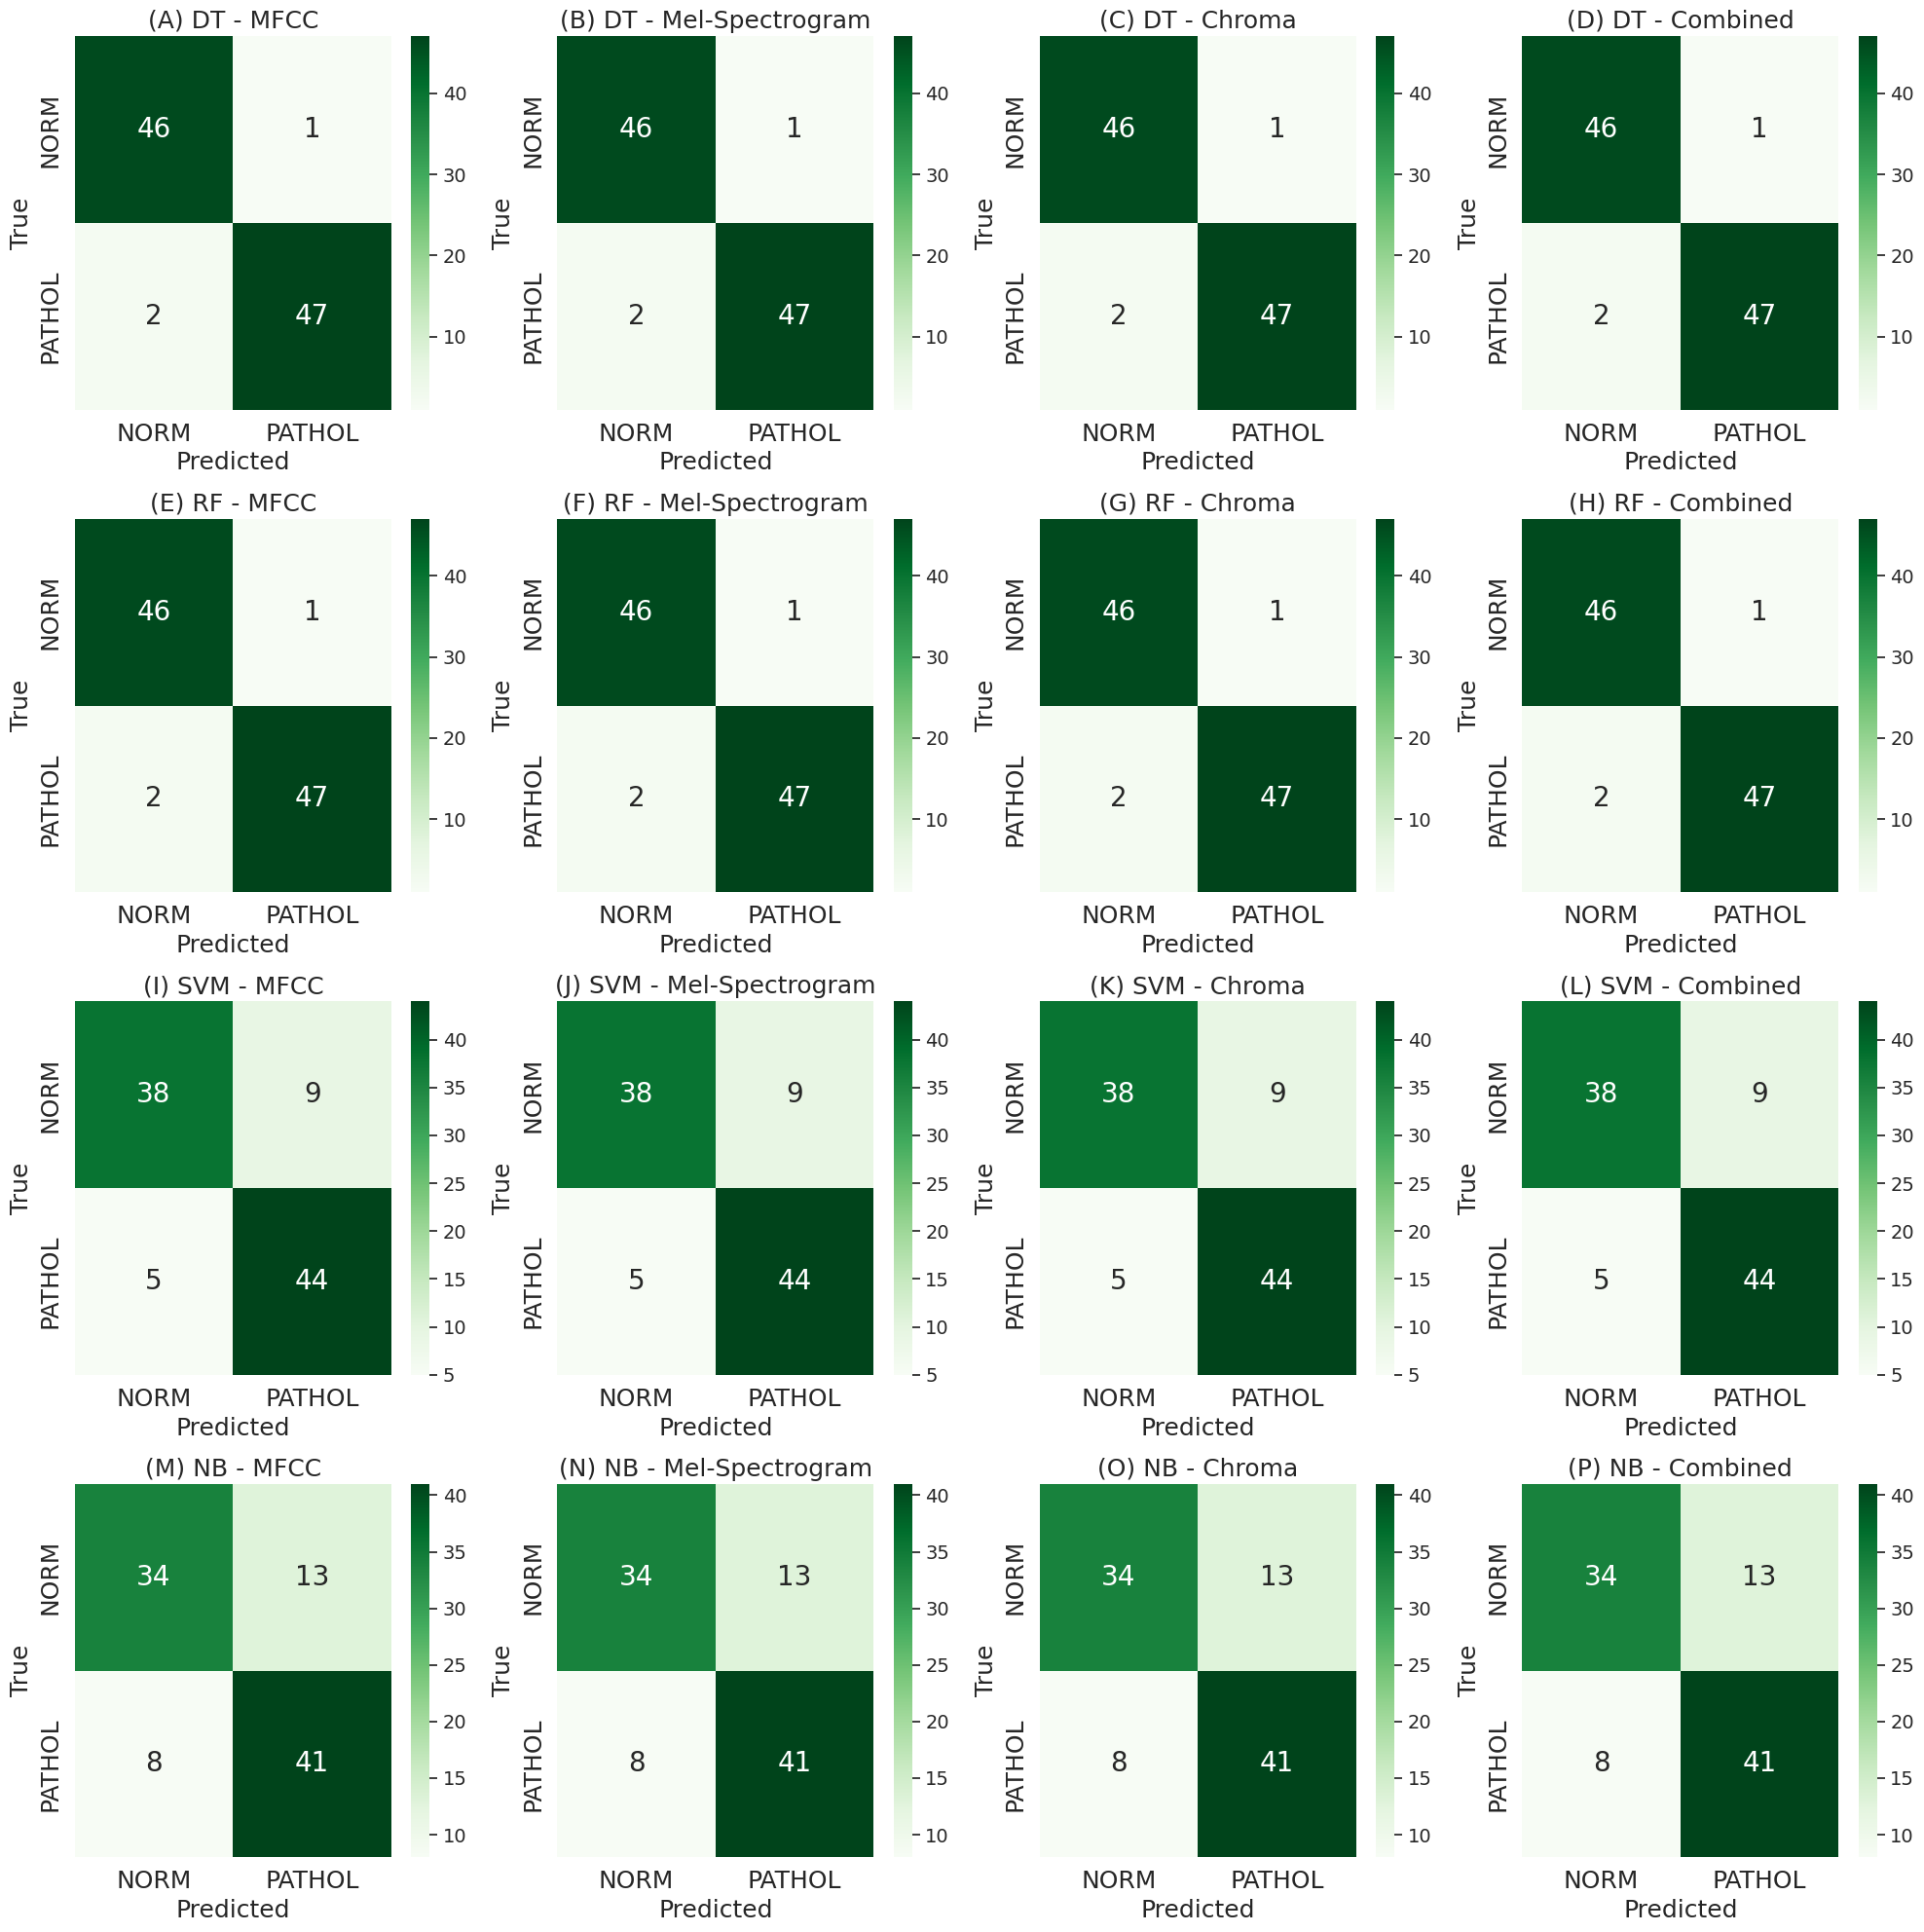

In [ ]:
import os
import numpy as np
import librosa
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import glob
import matplotlib.pyplot as plt

# Create subplots for the ROC curves
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

label_count = 0  # Counter to label plots
feature_sets = {
    'MFCC': X_mfcc_train,
    'Mel-Spectrogram': X_mel_train,
    'Chroma': X_chroma_train,
    'Combined': X_combined_train
}

# Later in your ROC curve plotting section:
for i, (model_name, classifier) in enumerate(classifiers.items()):
    for j, (feature_set_name, X_train) in enumerate(feature_sets.items()):
        # Predict on the test set (assumes models are already trained)
        Y_pred = classifier.predict(X_test)
        # Compute confusion matrix
        from sklearn.metrics import confusion_matrix # Import confusion_matrix
        cm = confusion_matrix(Y_test, Y_pred)

        # Plot the confusion matrix
        ax = axes[i, j]  # Get the corresponding subplot
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes, ax=ax,
                    annot_kws={"size": 20})

        ax.set_title(f'({chr(65 + label_count)}) {model_name} - {feature_set_name}', fontsize=18)
        ax.set_xlabel('Predicted', fontsize=18)
        ax.set_ylabel('True', fontsize=18)

        # Adjust tick font size
        ax.tick_params(axis='both', which='major', labelsize=18)

        # Adjust colorbar tick size
        colorbar = ax.collections[0].colorbar
        colorbar.ax.tick_params(labelsize=14)  # Set colorbar tick font size to 14

        label_count += 1


# Adjust layout and show the plot
plt.tight_layout()
plt.show()

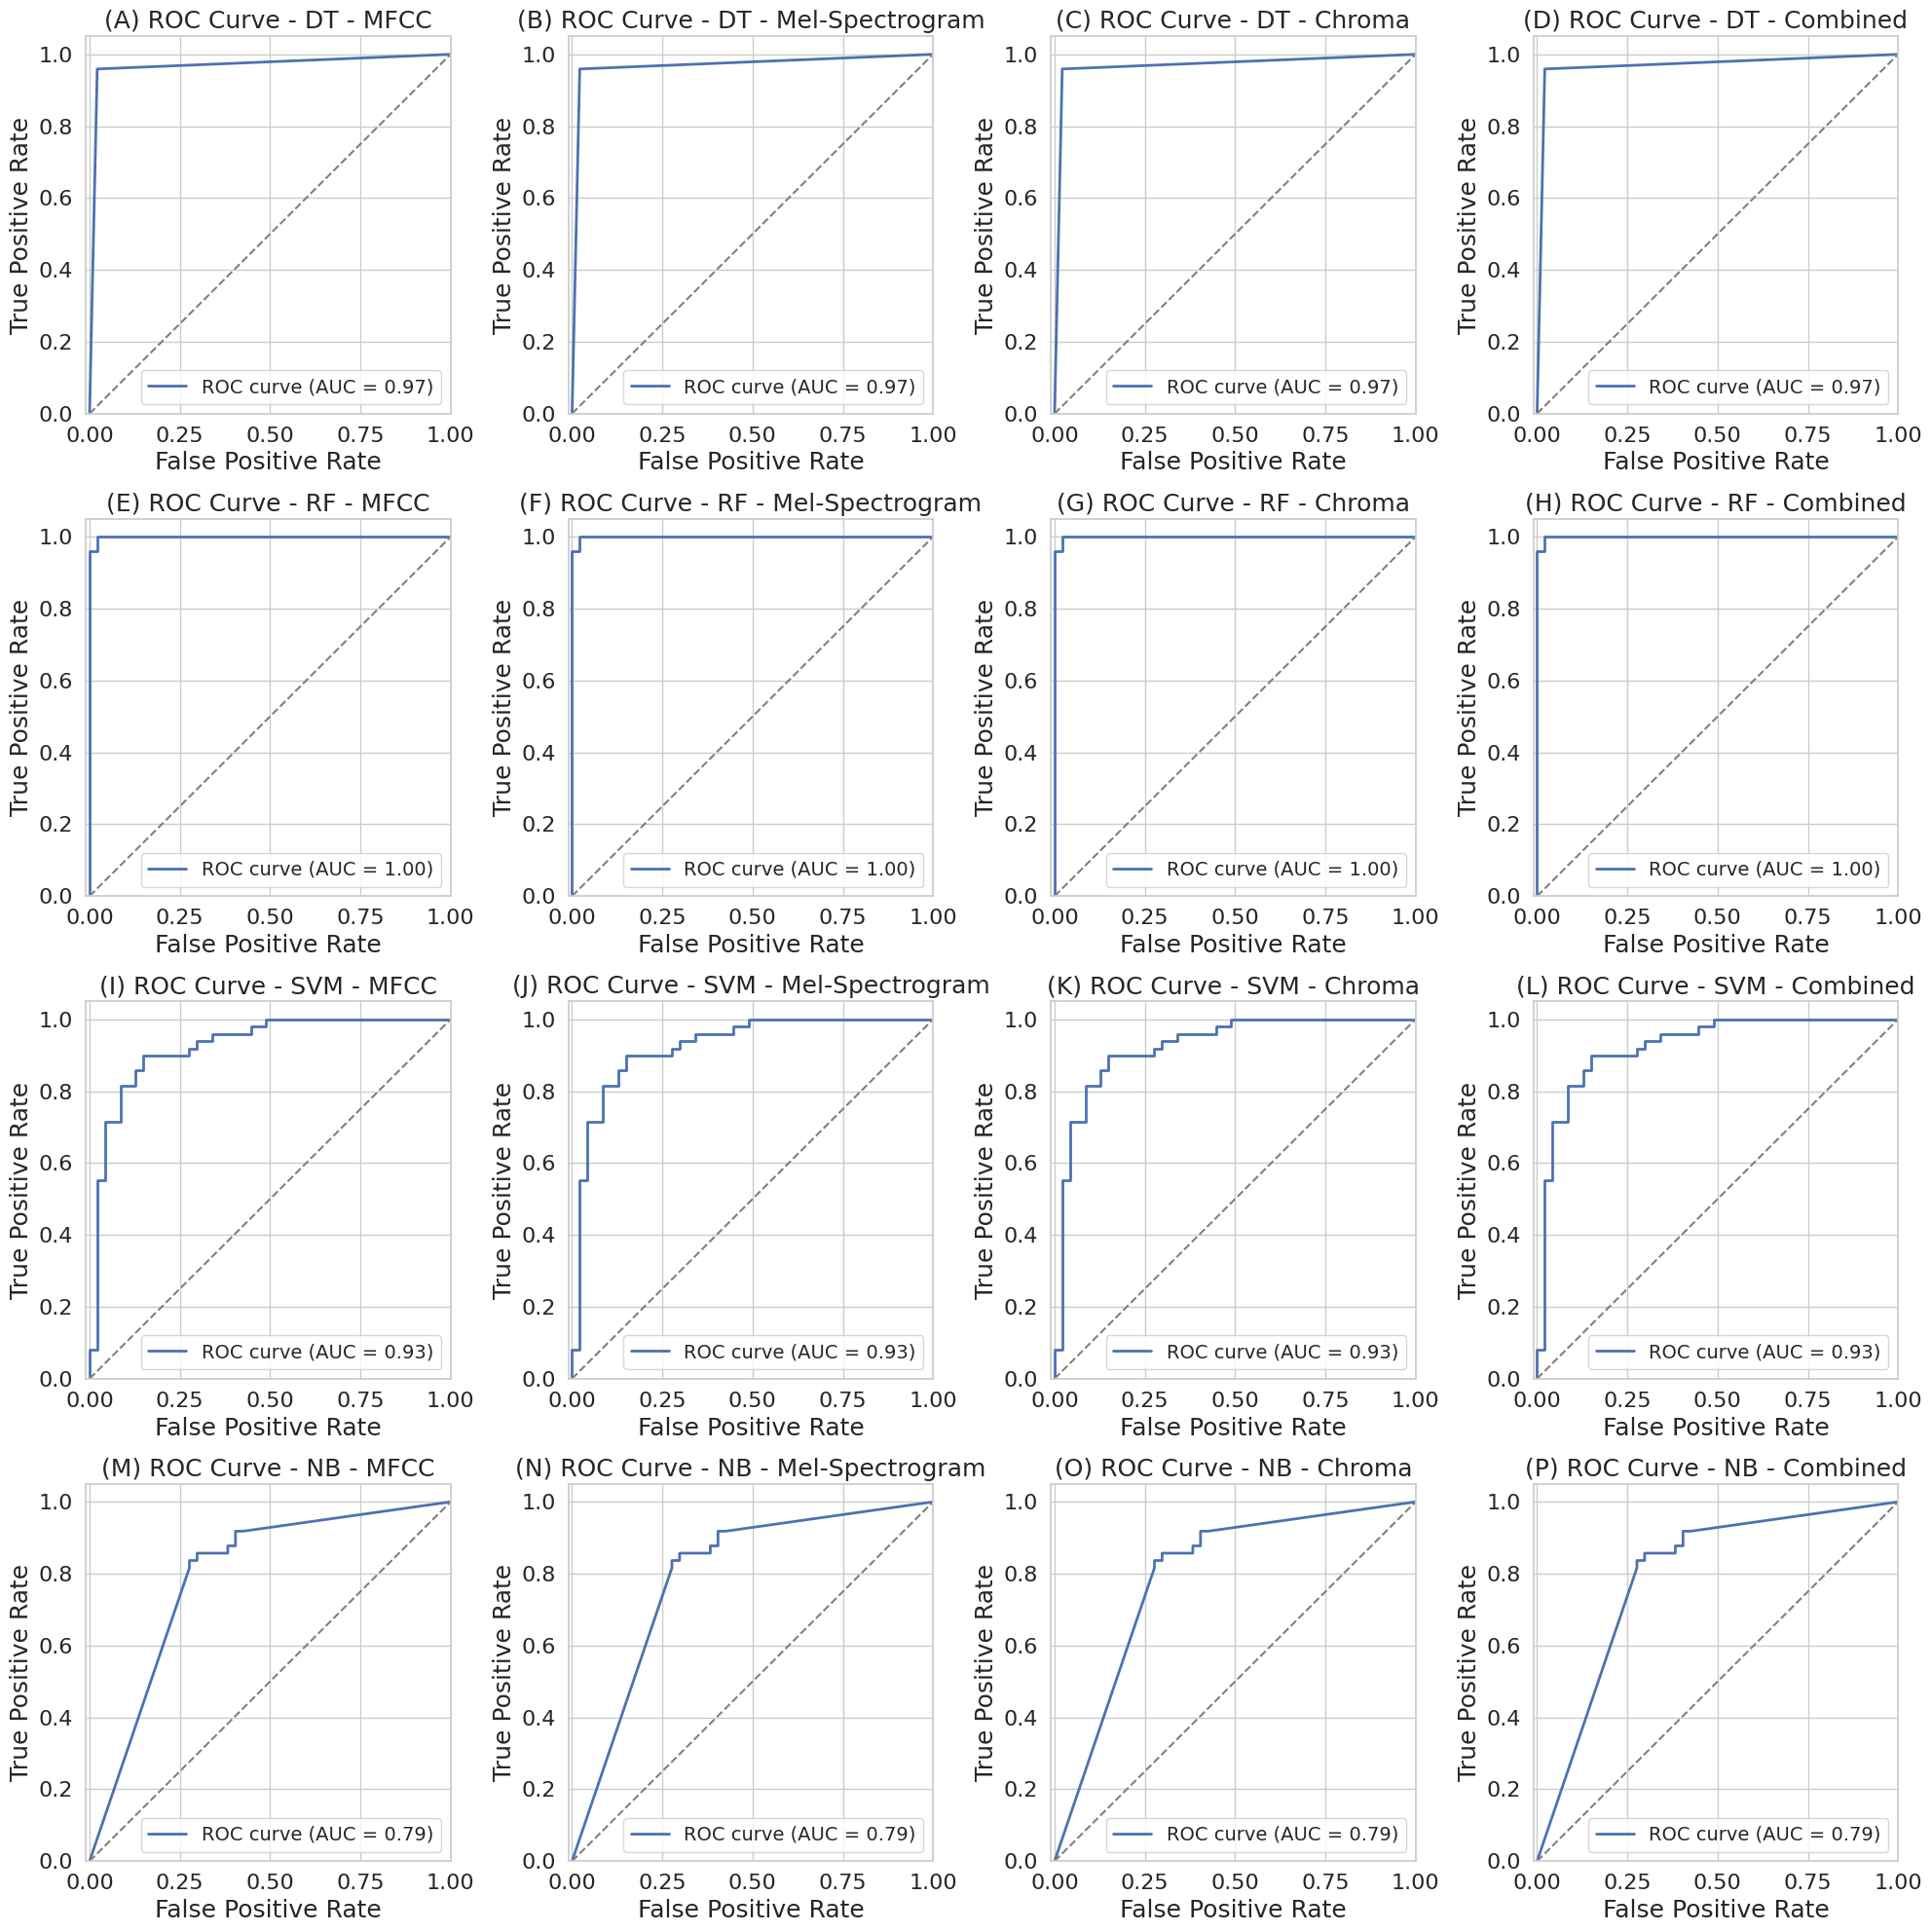

In [ ]:
import os
import numpy as np
import librosa
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import glob
import matplotlib.pyplot as plt

# Create subplots for the ROC curves
fig, axes = plt.subplots(4, 4, figsize=(20,20))

label_count = 0  # Counter to label plots


# Later in your ROC curve plotting section:
for i, (model_name, classifier) in enumerate(classifiers.items()):
    for j, (feature_set_name, X_train) in enumerate(feature_sets.items()):
        # Predict on the test set (assumes models are already trained)
        Y_pred = classifier.predict(X_test)

        # Compute ROC curve and AUC for the current model
        fpr, tpr, _ = roc_curve(Y_test, classifier.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve
        ax_roc = axes[i, j]  # Get the corresponding subplot for ROC curve
        ax_roc.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        ax_roc.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (chance level)
        ax_roc.set_xlim([-0.01, 1.0])  # Set x-axis to start from -0.01
        ax_roc.set_ylim([0.0, 1.05])  # Set y-axis to [0, 1]
        ax_roc.set_title(f'({chr(65 + label_count)}) ROC Curve - {model_name} - {feature_set_name}', fontsize=18)
        ax_roc.set_xlabel('False Positive Rate', fontsize=18)
        ax_roc.set_ylabel('True Positive Rate', fontsize=18)
        ax_roc.tick_params(axis='both', which='major', labelsize=16)
        ax_roc.legend(loc='lower right', fontsize=14)

        label_count += 1

# Adjust layout and show the plot
plt.tight_layout()
plt.show()




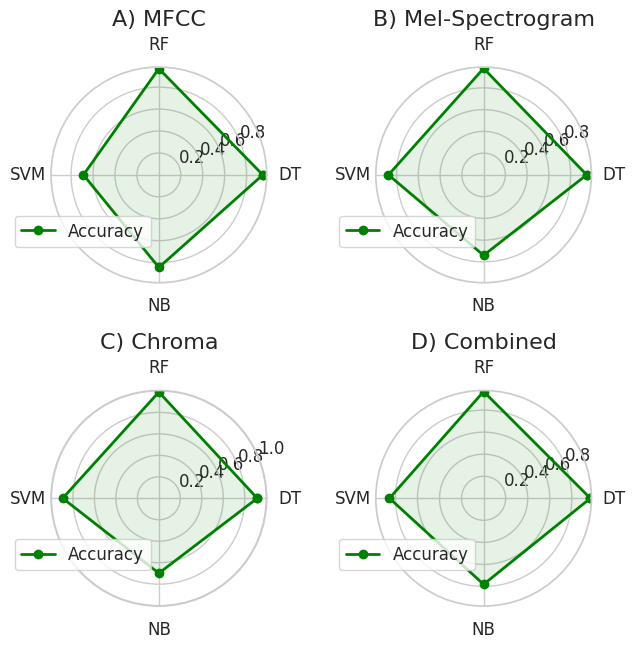

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming metrics_df is already created as in your previous code

# Feature sets and classifiers to plot


# Create a figure and axes for the subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 7), subplot_kw={'polar': True})  # Polar plots

for i, feature_set in enumerate(feature_sets):
    ax = axes.flatten()[i]  # Get the current subplot

    # Filter the metrics_df for the current feature set
    feature_set_df = metrics_df[metrics_df['Feature Set'] == feature_set]

    # Get the accuracy values for each classifier
    accuracies = feature_set_df['Accuracy'].values

    # Calculate angles based on the number of classifiers
    angles = np.linspace(0, 2 * np.pi, len(classifiers), endpoint=False)

    # Create the radar plot for Accuracy
    ax.plot(np.concatenate((angles, [angles[0]])), np.concatenate((accuracies, [accuracies[0]])), 'o-', linewidth=2, label="Accuracy",color='green')
    ax.fill(np.concatenate((angles, [angles[0]])), np.concatenate((accuracies, [accuracies[0]])), alpha=0.10,color='green')

    # Set the category labels (classifiers)
    ax.set_thetagrids(angles * 180 / np.pi, classifiers, fontsize=14)

    # Set title with lettering (A), B), C), D)
    letter = chr(ord('A') + i)  # Get the letter (A, B, C, D)
    ax.set_title(f'{letter}) {feature_set}', fontsize=16, pad=30)  # Set title with lettering and padding

    ax.grid(True)

    # Add legend to show "Accuracy"
    ax.legend(bbox_to_anchor=(0.5, 0.35), fontsize=12)  # Set legend font size to 14

    # Increase tick label font size
    ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust layout and show the plot with all four subplots
fig.subplots_adjust(hspace=0.5, wspace=0.1)
plt.show()

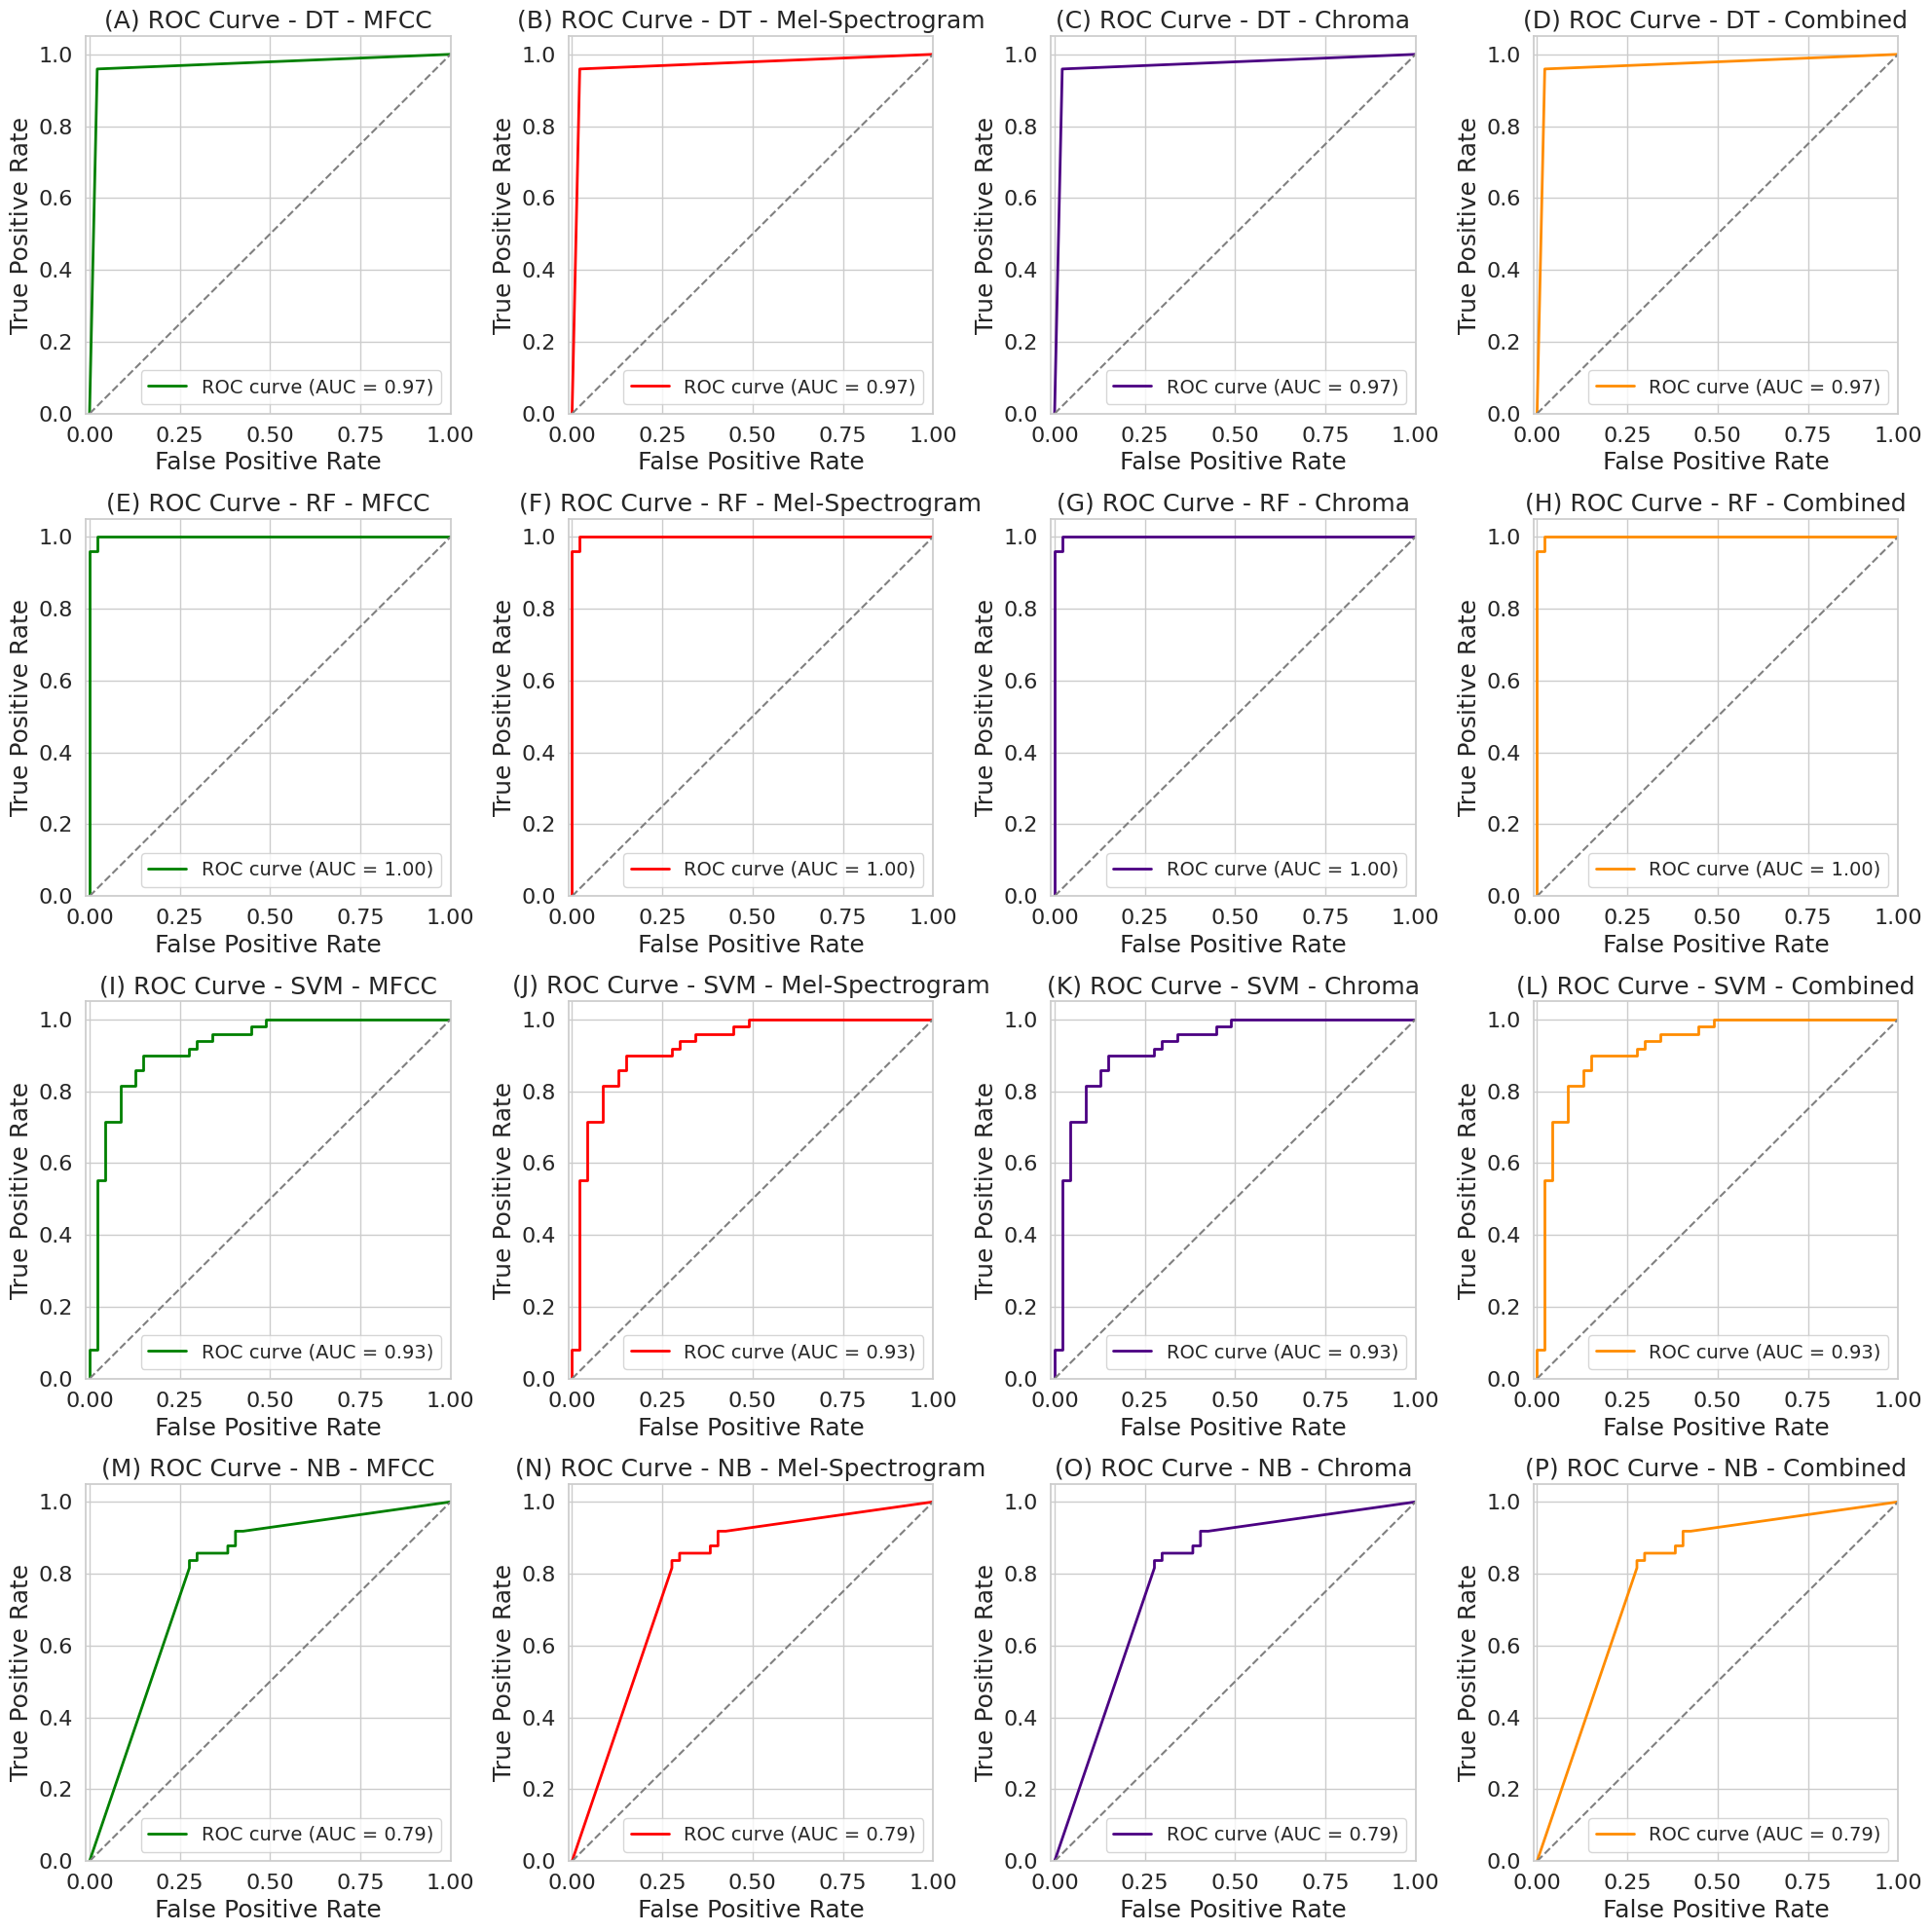

In [ ]:
import os
import numpy as np
import librosa
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import glob
import matplotlib.pyplot as plt

# Define colors for each column (feature set)
colors = ['green', 'red', 'indigo', 'darkorange']  # Colors for each column/feature set

# Create subplots for the ROC curves
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

label_count = 0  # Counter to label plots

# Loop through models and feature sets for ROC curve plotting
for i, (model_name, classifier) in enumerate(classifiers.items()):
    for j, (feature_set_name, X_train) in enumerate(feature_sets.items()):
        # Predict on the test set (assumes models are already trained)
        Y_pred = classifier.predict(X_test)

        # Compute ROC curve and AUC for the current model
        fpr, tpr, _ = roc_curve(Y_test, classifier.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve
        ax_roc = axes[i, j]  # Get the corresponding subplot for ROC curve
        color = colors[j]  # Use the column's color
        ax_roc.plot(fpr, tpr, color=color, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        ax_roc.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (chance level)
        ax_roc.set_xlim([-0.01, 1.0])  # Set x-axis to start from -0.01
        ax_roc.set_ylim([0.0, 1.05])  # Set y-axis to [0, 1]
        ax_roc.set_title(f'({chr(65 + label_count)}) ROC Curve - {model_name} - {feature_set_name}', fontsize=18)
        ax_roc.set_xlabel('False Positive Rate', fontsize=18)
        ax_roc.set_ylabel('True Positive Rate', fontsize=18)
        ax_roc.tick_params(axis='both', which='major', labelsize=16)
        ax_roc.legend(loc='lower right', fontsize=14)

        label_count += 1

# Adjust layout and show the plot
plt.tight_layout()
plt.show()



In [ ]:
# prompt: like roc plot in previous code make accuracy, precision, recall and F1 score plot acorss all models and Features set

import matplotlib.pyplot as plt

# Assuming metrics_df is already created with columns:
# 'Classifier', 'Feature Set', 'Accuracy', 'Precision', 'Recall', 'F1 Score'

def plot_metrics(metrics_df):
    """Plots accuracy, precision, recall, and F1 score across all models and feature sets."""


    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()  # Flatten the axes array for easier iteration

    for i, metric in enumerate(metrics):
        ax = axes[i]
        for feature_set in feature_sets:
            subset = metrics_df[(metrics_df['Feature Set'] == feature_set)]
            ax.plot(subset['Classifier'], subset[metric], label=feature_set, marker='o')

        ax.set_xlabel("Classifiers")
        ax.set_ylabel(metric)
        ax.set_title(f"{metric} Comparison")
        ax.legend()
        ax.set_xticklabels(classifiers, rotation=45, ha='right')  # Rotate x-axis labels

    plt.tight_layout()
    plt.show()

# Example usage (assuming metrics_df is defined):
# plot_metrics(metrics_df)

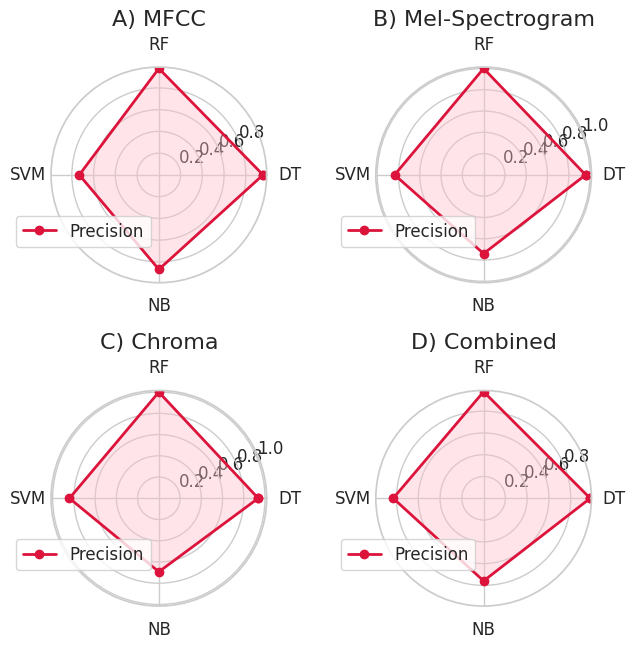

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming metrics_df is already created as in your previous code

# Feature sets and classifiers to plot
feature_sets = ['MFCC', 'Mel-Spectrogram', 'Chroma', 'Combined']
classifiers = metrics_df['Classifier'].unique()

# Create a figure and axes for the subplots
fig, axes = plt.subplots(2, 2, figsize=(8,7), subplot_kw={'polar': True})  # Polar plots

for i, feature_set in enumerate(feature_sets):
    ax = axes.flatten()[i]  # Get the current subplot

    # Filter the metrics_df for the current feature set
    feature_set_df = metrics_df[metrics_df['Feature Set'] == feature_set]

    # Get the accuracy values for each classifier
    accuracies = feature_set_df['Precision'].values

    # Calculate angles based on the number of classifiers
    angles = np.linspace(0, 2 * np.pi, len(classifiers), endpoint=False)

    # Create the radar plot for Accuracy
    ax.plot(np.concatenate((angles, [angles[0]])), np.concatenate((accuracies, [accuracies[0]])), 'o-', linewidth=2, label="Precision",color='crimson')
    ax.fill(np.concatenate((angles, [angles[0]])), np.concatenate((accuracies, [accuracies[0]])), alpha=0.40,color='pink')

    # Set the category labels (classifiers)
    ax.set_thetagrids(angles * 180 / np.pi, classifiers, fontsize=14)

    # Set title with lettering (A), B), C), D)
    letter = chr(ord('A') + i)  # Get the letter (A, B, C, D)
    ax.set_title(f'{letter}) {feature_set}', fontsize=16, pad=30)  # Set title with lettering and padding


    ax.grid(True)

    # Add legend to show "Accuracy"
    ax.legend(bbox_to_anchor=(0.5, 0.35), fontsize=12)  # Set legend font size to 14

    # Increase tick label font size
    ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust layout and show the plot with all four subplots
fig.subplots_adjust(hspace=0.5, wspace=0.1)
plt.show()

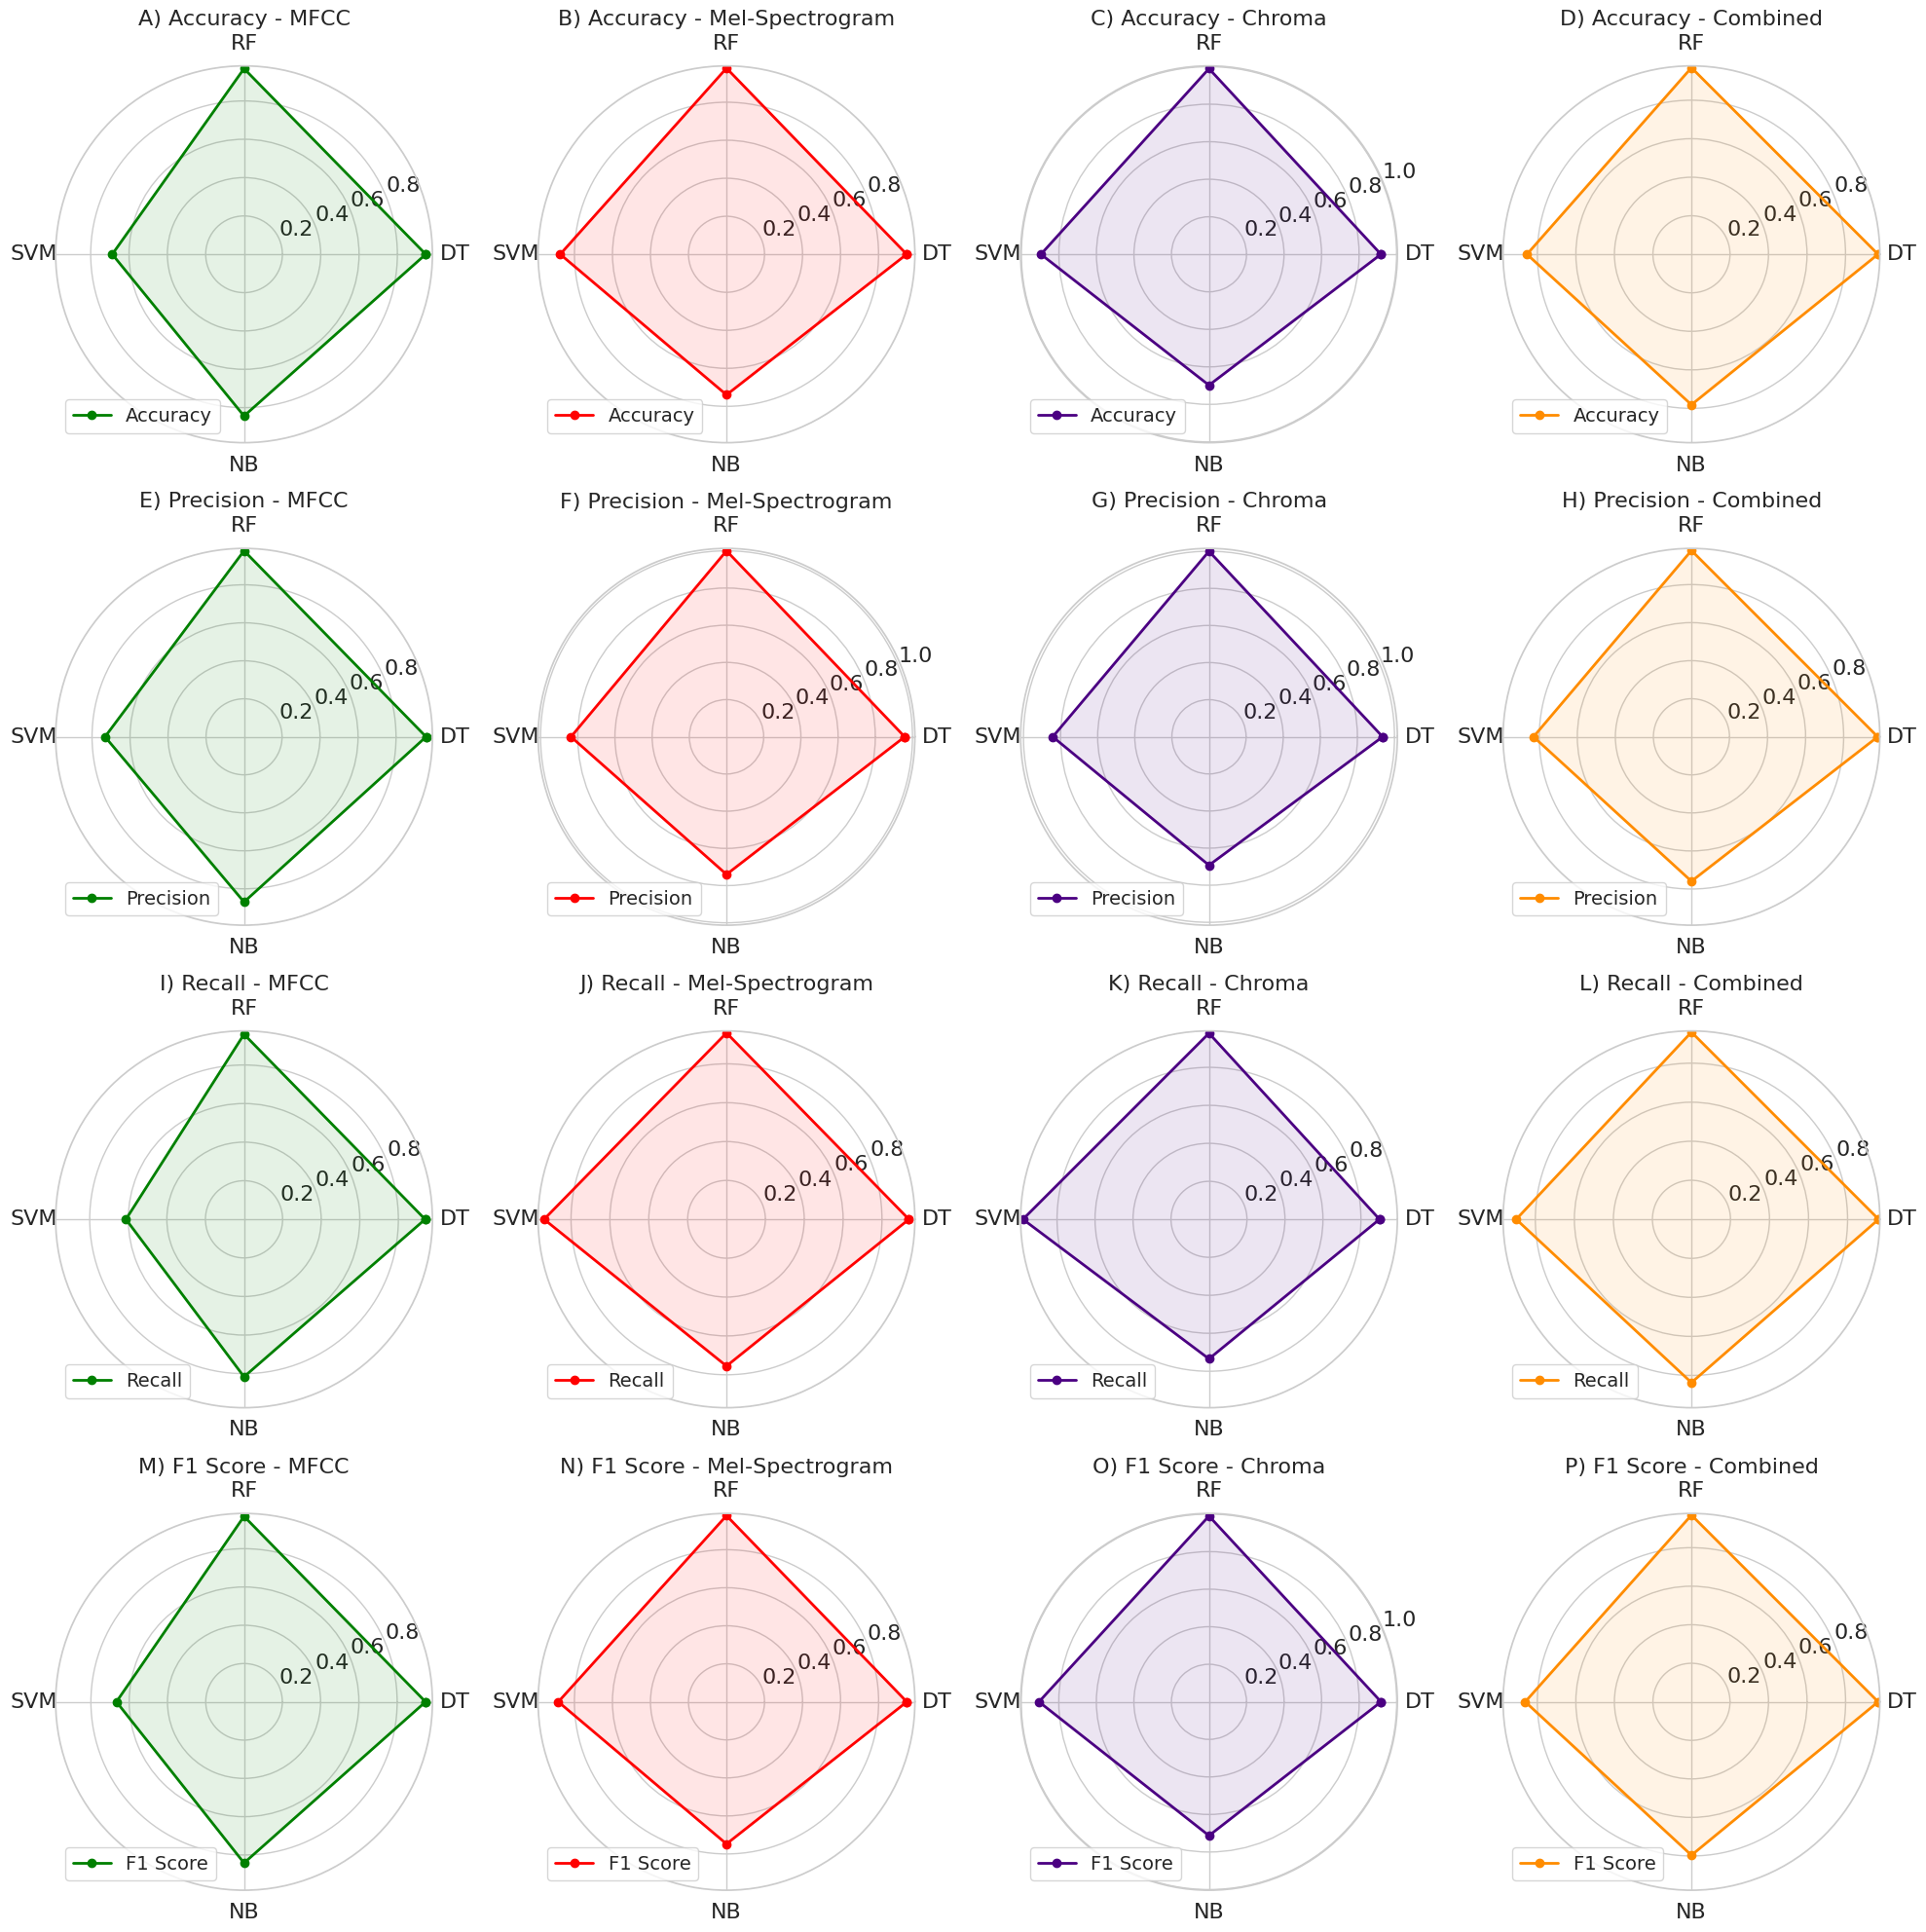

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming metrics_df is already created with columns for 'Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Score', and 'Feature Set'

# Feature sets and classifiers to plot


# Create a figure and axes for the subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 20), subplot_kw={'polar': True})  # 4x4 grid of polar plots

# Define colors for each column (feature set)
colors = ['green', 'red', 'indigo', 'darkorange']  # Colors for each column/feature set

# Metric names
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Loop through metrics (rows)
for i, metric in enumerate(metrics):
    for j, feature_set in enumerate(feature_sets):
        # Get the corresponding axis for the current subplot
        ax = axes[i, j]  # 4 rows, 4 columns

        # Filter the metrics_df for the current feature set
        feature_set_df = metrics_df[metrics_df['Feature Set'] == feature_set]

        # Get the values for the current metric
        metric_values = feature_set_df[metric].values

        # Calculate angles based on the number of classifiers
        angles = np.linspace(0, 2 * np.pi, len(classifiers), endpoint=False)

        # Create the radar plot for the current metric
        ax.plot(
            np.concatenate((angles, [angles[0]])),
            np.concatenate((metric_values, [metric_values[0]])),
            'o-', linewidth=2, label=metric, color=colors[j]
        )
        ax.fill(
            np.concatenate((angles, [angles[0]])),
            np.concatenate((metric_values, [metric_values[0]])),
            alpha=0.10, color=colors[j]
        )

        # Set the category labels (classifiers)
        ax.set_thetagrids(angles * 180 / np.pi, classifiers, fontsize=14)

        # Set title with lettering (A, B, C, ...)
        letter = chr(ord('A') + i * 4 + j)  # Get the letter (A, B, C, ...)
        ax.set_title(f'{letter}) {metric} - {feature_set}', fontsize=16, pad=30)



        # Add legend to show the metric name

        ax.legend(loc='lower left', fontsize=14)

        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=16)

# Adjust layout and show the plot with all sixteen subplots
plt.tight_layout()
plt.show()



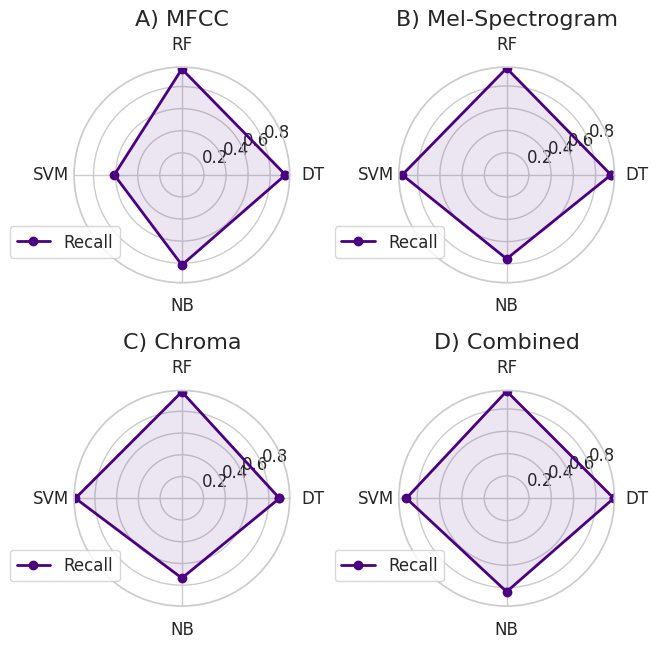

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming metrics_df is already created as in your previous code

# Feature sets and classifiers to plot
feature_sets = ['MFCC', 'Mel-Spectrogram', 'Chroma', 'Combined']
classifiers = metrics_df['Classifier'].unique()

# Create a figure and axes for the subplots
fig, axes = plt.subplots(2, 2, figsize=(8,7), subplot_kw={'polar': True})  # Polar plots

for i, feature_set in enumerate(feature_sets):
    ax = axes.flatten()[i]  # Get the current subplot

    # Filter the metrics_df for the current feature set
    feature_set_df = metrics_df[metrics_df['Feature Set'] == feature_set]

    # Get the accuracy values for each classifier
    accuracies = feature_set_df['Recall'].values

    # Calculate angles based on the number of classifiers
    angles = np.linspace(0, 2 * np.pi, len(classifiers), endpoint=False)

    # Create the radar plot for Accuracy
    ax.plot(np.concatenate((angles, [angles[0]])), np.concatenate((accuracies, [accuracies[0]])), 'o-', linewidth=2, label="Recall",color='indigo')
    ax.fill(np.concatenate((angles, [angles[0]])), np.concatenate((accuracies, [accuracies[0]])), alpha=0.10,color='indigo')

    # Set the category labels (classifiers)
    ax.set_thetagrids(angles * 180 / np.pi, classifiers, fontsize=14)

    # Set title with lettering (A), B), C), D)
    letter = chr(ord('A') + i)  # Get the letter (A, B, C, D)
    ax.set_title(f'{letter}) {feature_set}', fontsize=16, pad=30)  # Set title with lettering and padding


    ax.grid(True)

    # Add legend to show "Accuracy"
    ax.legend(bbox_to_anchor=(0.25, 0.3), fontsize=12)  # Set legend font size to 14
    # Increase tick label font size
    ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust layout and show the plot with all four subplots
fig.subplots_adjust(hspace=0.5, wspace=0.1)
plt.show()

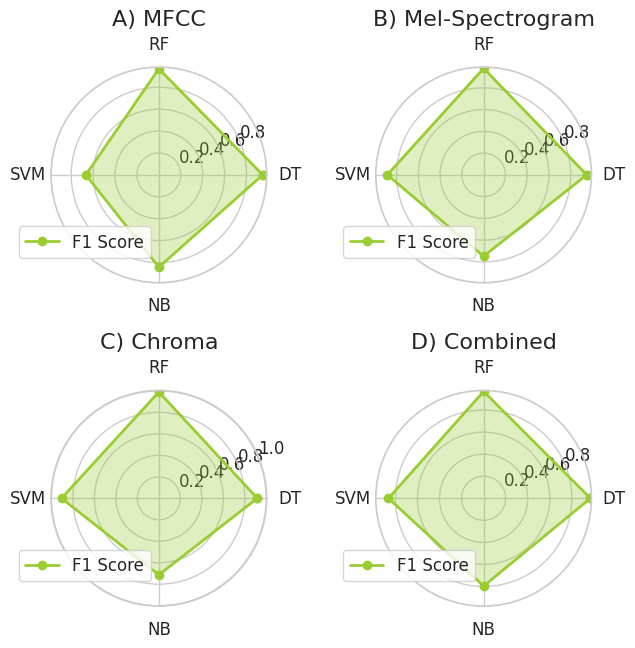

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming metrics_df is already created as in your previous code

# Feature sets and classifiers to plot
feature_sets = ['MFCC', 'Mel-Spectrogram', 'Chroma', 'Combined']
classifiers = metrics_df['Classifier'].unique()

# Create a figure and axes for the subplots
fig, axes = plt.subplots(2, 2, figsize=(8,7), subplot_kw={'polar': True})  # Polar plots

for i, feature_set in enumerate(feature_sets):
    ax = axes.flatten()[i]  # Get the current subplot

    # Filter the metrics_df for the current feature set
    feature_set_df = metrics_df[metrics_df['Feature Set'] == feature_set]

    # Get the accuracy values for each classifier
    accuracies = feature_set_df['F1 Score'].values

    # Calculate angles based on the number of classifiers
    angles = np.linspace(0, 2 * np.pi, len(classifiers), endpoint=False)

    # Create the radar plot for Accuracy
    ax.plot(np.concatenate((angles, [angles[0]])), np.concatenate((accuracies, [accuracies[0]])), 'o-', linewidth=2, label="F1 Score",color='yellowgreen')
    ax.fill(np.concatenate((angles, [angles[0]])), np.concatenate((accuracies, [accuracies[0]])), alpha=0.30,color='yellowgreen')

    # Set the category labels (classifiers)
    ax.set_thetagrids(angles * 180 / np.pi, classifiers, fontsize=14)

    # Set title with lettering (A), B), C), D)
    letter = chr(ord('A') + i)  # Get the letter (A, B, C, D)
    ax.set_title(f'{letter}) {feature_set}', fontsize=16, pad=30)  # Set title with lettering and padding


    ax.grid(True)

    # Add legend to show "Accuracy"
    ax.legend(bbox_to_anchor=(0.5, 0.3), fontsize=12)  # Set legend font size to 14

    # Increase tick label font size
    ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust layout and show the plot with all four subplots
fig.subplots_adjust(hspace=0.5, wspace=0.1)
plt.show()

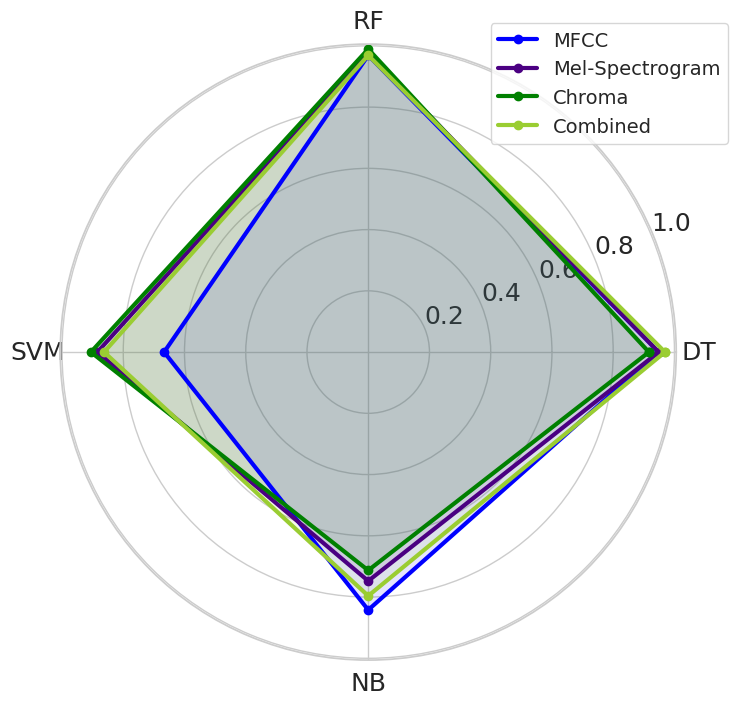

In [ ]:
# prompt: import matplotlib.pyplot as plt
# import numpy as np
# # Assuming metrics_df is already created as in your original code
# # Define categories for the radar plot (only Accuracy)
# categories = ['F1 Score']
# # Create a figure and axes for the subplots
# fig, axes = plt.subplots(2, 2, figsize=(12, 10), subplot_kw={'polar': True})  # Polar plots
# # Feature sets to plot
# feature_sets = ['MFCC', 'Mel-Spectrogram', 'Chroma', 'Combined']
# # ... (rest of your code) ...
# for i, feature_set in enumerate(feature_sets):
#     ax = axes.flatten()[i]  # Get the current subplot
#     # ... (rest of your code) ...
#     # Calculate angles based on the number of classifiers
#     angles = np.linspace(0, 2 * np.pi, len(classifiers), endpoint=False)
#     # Create the radar plot for Accuracy
#     ax.plot(np.concatenate((angles, [angles[0]])), np.concatenate((accuracies, [accuracies[0]])), 'o-', linewidth=2, label="F1 Score", color='indigo')
#     ax.fill(np.concatenate((angles, [angles[0]])), np.concatenate((accuracies, [accuracies[0]])), alpha=0.10, color='indigo')
#     ax.set_thetagrids(angles * 180 / np.pi, classifiers, fontsize=18)  # Set classifier labels as thetagrids with font size 18
#     # Set title with lettering (A), B), C), D)
#     letter = chr(ord('A') + i)  # Get the letter (A, B, C, D)
#     ax.set_title(f'{letter}) {feature_set}', fontsize=18, pad=40)  # Set title with lettering and padding
#     ax.grid(True)
#     # Add legend to show "Accuracy"
#     ax.legend(bbox_to_anchor=(0.4, 0.80), fontsize=14)  # Set legend font size to 18
#     # Increase tick label font size
#     ax.tick_params(axis='both', which='major', labelsize=14)
# # Adjust layout and show the plot with all four subplots
# fig.subplots_adjust(hspace=0.5, wspace=0.1)
# plt.show() show all F1 score  plot in one plot use spefcific colors and use different colors for features too

import matplotlib.pyplot as plt
import numpy as np

# Assuming metrics_df is already created and contains 'Classifier', 'Feature Set', and relevant metrics columns

# Define colors for each feature set
feature_colors = {'MFCC': 'blue', 'Mel-Spectrogram': 'indigo', 'Chroma': 'green', 'Combined': 'yellowgreen'}

# Define colors for each classifier
classifier_colors = {'DT': 'blue', 'RF': 'red', 'SVM': 'green', 'NB': 'orange'}


# Create the radar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})  # Single plot


# Calculate angles based on the number of classifiers
angles = np.linspace(0, 2 * np.pi, len(classifiers), endpoint=False)

# Plot for each feature set
for feature_set in feature_sets:
  # Get metrics for the current feature set
  feature_data = metrics_df[metrics_df['Feature Set'] == feature_set]
  f1_scores = feature_data['F1 Score'].values

  #Plot data
  ax.plot(np.concatenate((angles, [angles[0]])), np.concatenate((f1_scores, [f1_scores[0]])), 'o-', linewidth=3, label=feature_set, color=feature_colors[feature_set])
  ax.fill(np.concatenate((angles, [angles[0]])), np.concatenate((f1_scores, [f1_scores[0]])), alpha=0.10, color=feature_colors[feature_set])


# Set classifier labels as theta grids
classifier_names = metrics_df['Classifier'].unique()

# ... (rest of your code) ...

# Set classifier labels as theta grids
ax.set_thetagrids(angles * 180 / np.pi, classifier_names, fontsize=14)


ax.grid(True)

# Add legend
ax.legend(fontsize=14, bbox_to_anchor=(1.1, 1.05)) # Adjusted for better positioning

# Increase tick label font size
ax.tick_params(axis='both', which='major', labelsize=18)


plt.show()

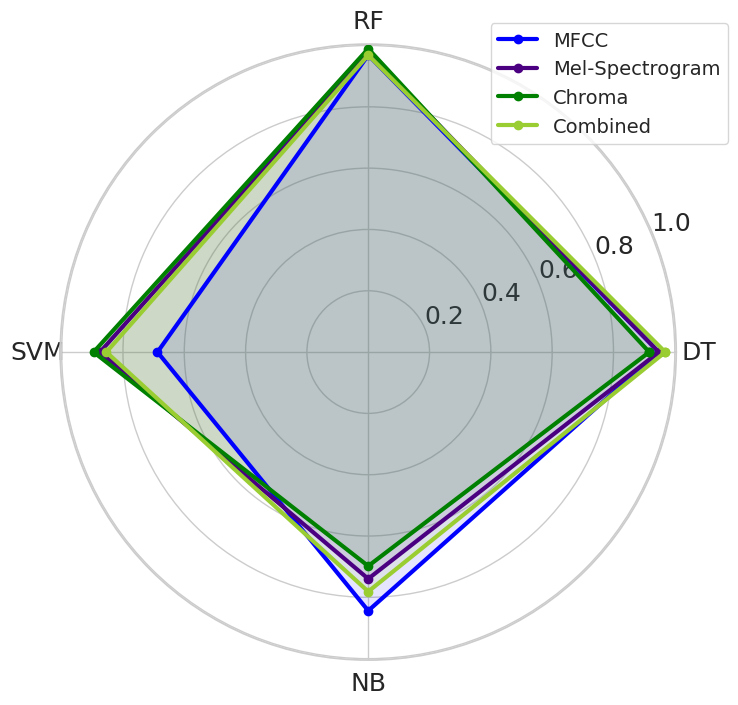

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming metrics_df is already created and contains 'Classifier', 'Feature Set', and relevant metrics columns

# Define colors for each feature set
feature_colors = {'MFCC': 'blue', 'Mel-Spectrogram': 'indigo', 'Chroma': 'green', 'Combined': 'yellowgreen'}

# Define colors for each classifier
classifier_colors = {'DT': 'blue', 'RF': 'red', 'SVM': 'green', 'NB': 'orange'}


# Create the radar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})  # Single plot


# Calculate angles based on the number of classifiers
angles = np.linspace(0, 2 * np.pi, len(classifiers), endpoint=False)

# Plot for each feature set
for feature_set in feature_sets:
  # Get metrics for the current feature set
  feature_data = metrics_df[metrics_df['Feature Set'] == feature_set]
  f1_scores = feature_data['Accuracy'].values

  #Plot data
  ax.plot(np.concatenate((angles, [angles[0]])), np.concatenate((f1_scores, [f1_scores[0]])), 'o-', linewidth=3, label=feature_set, color=feature_colors[feature_set])
  ax.fill(np.concatenate((angles, [angles[0]])), np.concatenate((f1_scores, [f1_scores[0]])), alpha=0.10, color=feature_colors[feature_set])


# Set classifier labels as theta grids
classifier_names = metrics_df['Classifier'].unique()

# ... (rest of your code) ...

# Set classifier labels as theta grids
ax.set_thetagrids(angles * 180 / np.pi, classifier_names, fontsize=14)


ax.grid(True)

# Add legend
ax.legend(fontsize=14, bbox_to_anchor=(1.1, 1.05)) # Adjusted for better positioning

# Increase tick label font size
ax.tick_params(axis='both', which='major', labelsize=18)


plt.show()

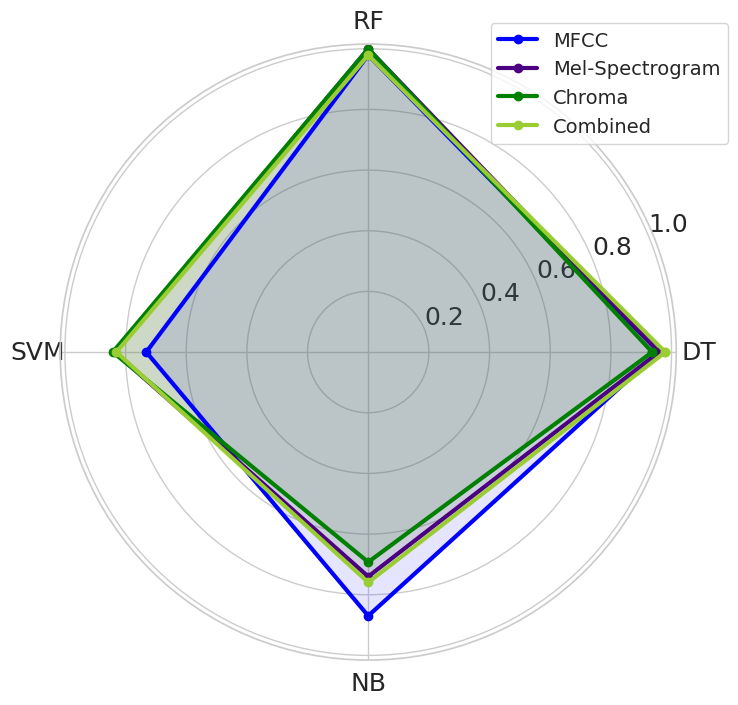

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming metrics_df is already created and contains 'Classifier', 'Feature Set', and relevant metrics columns

# Define colors for each feature set
feature_colors = {'MFCC': 'blue', 'Mel-Spectrogram': 'indigo', 'Chroma': 'green', 'Combined': 'yellowgreen'}
# Define colors for each classifier
classifier_colors = {'DT': 'blue', 'RF': 'red', 'SVM': 'green', 'NB': 'orange'}


# Create the radar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})  # Single plot


# Calculate angles based on the number of classifiers
angles = np.linspace(0, 2 * np.pi, len(classifiers), endpoint=False)

# Plot for each feature set
for feature_set in feature_sets:
  # Get metrics for the current feature set
  feature_data = metrics_df[metrics_df['Feature Set'] == feature_set]
  f1_scores = feature_data['Precision'].values

  #Plot data
  ax.plot(np.concatenate((angles, [angles[0]])), np.concatenate((f1_scores, [f1_scores[0]])), 'o-', linewidth=3, label=feature_set, color=feature_colors[feature_set])
  ax.fill(np.concatenate((angles, [angles[0]])), np.concatenate((f1_scores, [f1_scores[0]])), alpha=0.10, color=feature_colors[feature_set])


# Set classifier labels as theta grids
classifier_names = metrics_df['Classifier'].unique()

# ... (rest of your code) ...

# Set classifier labels as theta grids
ax.set_thetagrids(angles * 180 / np.pi, classifier_names, fontsize=14)


ax.grid(True)

# Add legend
ax.legend(fontsize=14, bbox_to_anchor=(1.1, 1.05)) # Adjusted for better positioning

# Increase tick label font size
ax.tick_params(axis='both', which='major', labelsize=18)


plt.show()

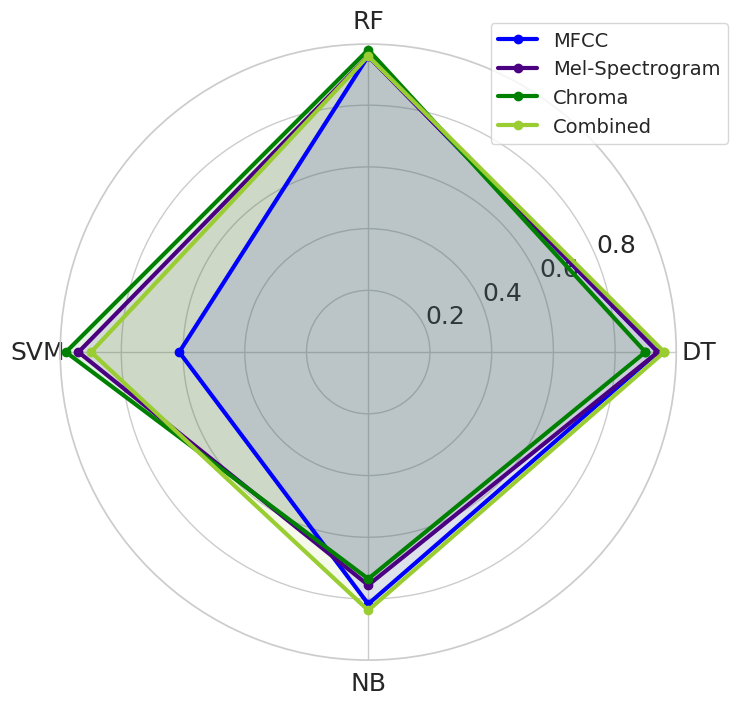

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming metrics_df is already created and contains 'Classifier', 'Feature Set', and relevant metrics columns

# Define colors for each feature set
feature_colors = {'MFCC': 'blue', 'Mel-Spectrogram': 'indigo', 'Chroma': 'green', 'Combined': 'yellowgreen'}

# Define colors for each classifier
classifier_colors = {'DT': 'blue', 'RF': 'red', 'SVM': 'green', 'NB': 'orange'}


# Create the radar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})  # Single plot


# Calculate angles based on the number of classifiers
angles = np.linspace(0, 2 * np.pi, len(classifiers), endpoint=False)

# Plot for each feature set
for feature_set in feature_sets:
  # Get metrics for the current feature set
  feature_data = metrics_df[metrics_df['Feature Set'] == feature_set]
  f1_scores = feature_data['Recall'].values

  #Plot data
  ax.plot(np.concatenate((angles, [angles[0]])), np.concatenate((f1_scores, [f1_scores[0]])), 'o-', linewidth=3, label=feature_set, color=feature_colors[feature_set])
  ax.fill(np.concatenate((angles, [angles[0]])), np.concatenate((f1_scores, [f1_scores[0]])), alpha=0.10, color=feature_colors[feature_set])


# Set classifier labels as theta grids
classifier_names = metrics_df['Classifier'].unique()

# ... (rest of your code) ...

# Set classifier labels as theta grids
ax.set_thetagrids(angles * 180 / np.pi, classifier_names, fontsize=14)


ax.grid(True)

# Add legend
ax.legend(fontsize=14, bbox_to_anchor=(1.1, 1.05)) # Adjusted for better positioning

# Increase tick label font size
ax.tick_params(axis='both', which='major', labelsize=18)


plt.show()

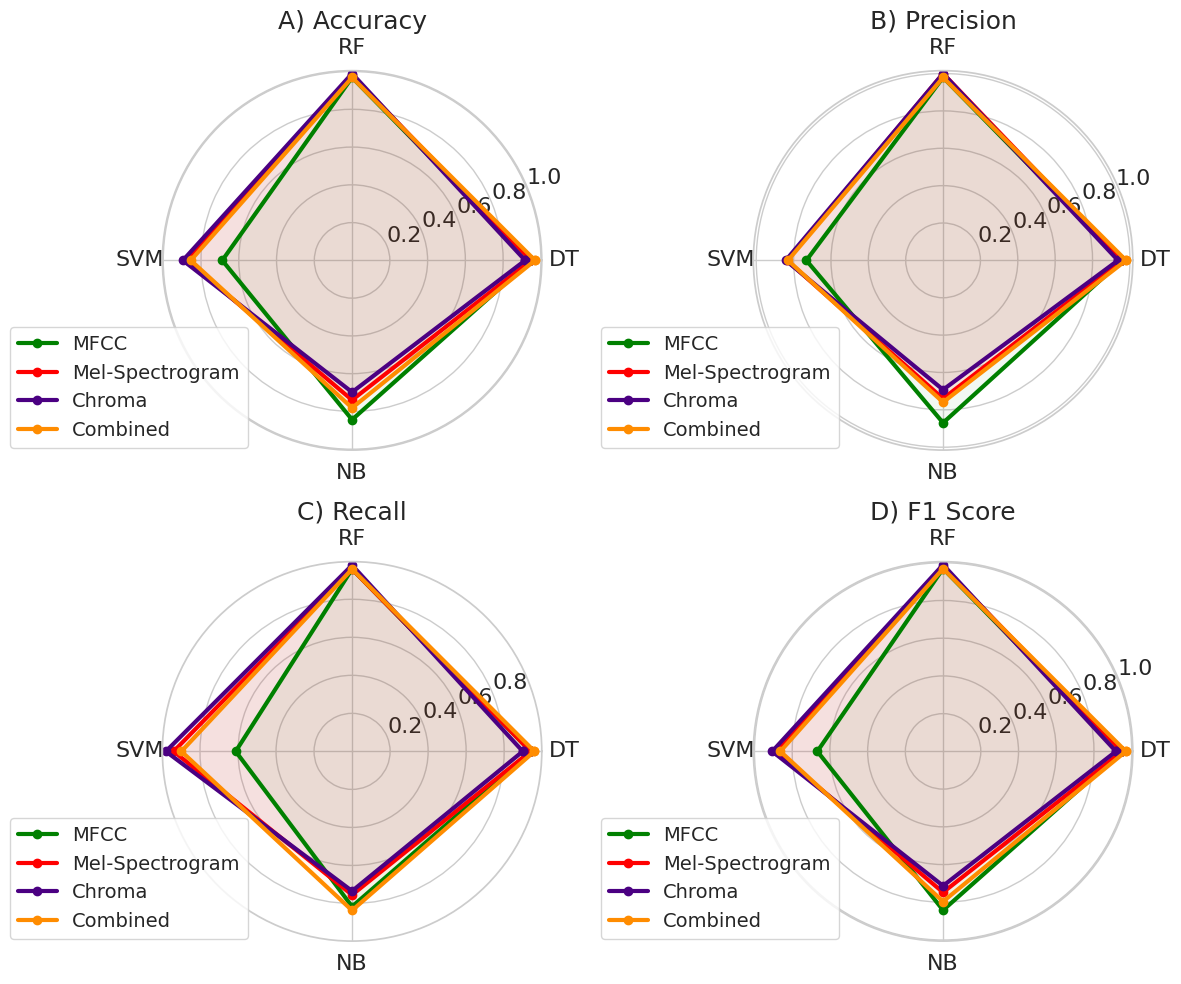

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming metrics_df is already created and contains 'Classifier', 'Feature Set', and relevant metrics columns

# Define colors for each feature set
feature_colors = {'MFCC': 'green', 'Mel-Spectrogram': 'red', 'Chroma': 'indigo', 'Combined': 'darkorange'}


# Define the feature sets and metrics to plot
feature_sets = metrics_df['Feature Set'].unique()
classifiers = metrics_df['Classifier'].unique()
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']  # List of metrics to plot

# Create a 2x2 grid for the plots
fig, axs = plt.subplots(2, 2, figsize=(12,10), subplot_kw={'projection': 'polar'})

# List of plot titles in order
plot_titles = ['A)', 'B)', 'C)', 'D)']

# Loop through each metric and create the radar plots
for i, metric in enumerate(metrics):
    # Calculate position in the 2x2 grid
    ax = axs[i//2, i%2]  # Select the correct subplot (row, col)

    # Calculate angles based on the number of classifiers
    angles = np.linspace(0, 2 * np.pi, len(classifiers), endpoint=False)

    # Plot for each feature set
    for feature_set in feature_sets:
        # Get metrics for the current feature set and metric
        feature_data = metrics_df[metrics_df['Feature Set'] == feature_set]
        metric_scores = feature_data[metric].values

        # Plot data
        ax.plot(np.concatenate((angles, [angles[0]])), np.concatenate((metric_scores, [metric_scores[0]])), 'o-', linewidth=3, label=feature_set, color=feature_colors[feature_set])
        ax.fill(np.concatenate((angles, [angles[0]])), np.concatenate((metric_scores, [metric_scores[0]])), alpha=0.05, color=feature_colors[feature_set])

    # Set classifier labels as theta grids
    ax.set_thetagrids(angles * 180 / np.pi, classifiers, fontsize=18)

    # Set the title for each plot with A), B), C), D) labels
    ax.set_title(f"{plot_titles[i]} {metrics[i]}", fontsize=18, pad=30)

    # Grid and legend
    ax.grid(True)
    ax.legend(fontsize=14, bbox_to_anchor=(0.25, 0.35))  # Adjusted for better positioning

    # Increase tick label font size
    ax.tick_params(axis='both', which='major', labelsize=16)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

